# Library

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from operations import *
from utils import *
from dataset import TossingDataset
from plot import plot_genotype

# Random Seed

In [2]:
seed = 100
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Model

In [3]:
# A layer of all operations
class MixedLayer(nn.Module):
    def __init__(self, input_dim, output_dim, operation_dict):
        super(MixedLayer, self).__init__()

        self.layers = nn.ModuleList()
        for operation in operation_dict.keys():
            # Create corresponding layer
            layer = operation_dict[operation](input_dim, output_dim)
            self.layers.append(layer)

    def forward(self, x, weights):
        res = [w * layer(x) for w, layer in zip(weights, self.layers)]
        res = sum(res)
        
        return res
    
# A network with mixed layers
class Network(nn.Module):
    def __init__(self, num_layers, initial_input_dims, hidden_dim, output_dim):
        super(Network, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.layers = nn.ModuleList()
        self.operation_name_list = []
        self.output_dim = output_dim
        self.initial_input_dims = initial_input_dims
        self.num_initial_input = len(self.initial_input_dims)
        
        # Generate all the mixed layer
        for i in range(self.num_layers - 1):
                
            # All previous outputs and additional inputs
            for j in range(i + self.num_initial_input):
                
                if j < self.num_initial_input: # Input layer 
                    layer = MixedLayer(self.initial_input_dims[j], self.hidden_dim, operation_dict_diff_dim)
                    self.layers.append(layer)
                    self.operation_name_list.append(list(operation_dict_diff_dim.keys()))
                
                else: # Middle layers
                    layer = MixedLayer(self.hidden_dim, self.hidden_dim, operation_dict_same_dim)
                    self.layers.append(layer)
                    self.operation_name_list.append(list(operation_dict_same_dim.keys()))
                                                    
        # For the last output layer
        for input_dim in self.initial_input_dims:
            if input_dim == self.output_dim:
                self.layers.append(
                    MixedLayer(input_dim, self.output_dim, operation_dict_same_dim_out)
                )
                self.operation_name_list.append(list(operation_dict_same_dim_out.keys()))
            else:
                self.layers.append(
                    MixedLayer(input_dim, self.output_dim, operation_dict_diff_dim_out)
                )
                self.operation_name_list.append(list(operation_dict_diff_dim_out.keys()))
        
        for j in range(self.num_layers - 1):
            layer = MixedLayer(self.hidden_dim, self.output_dim, operation_dict_diff_dim_out)
            self.layers.append(layer)
            self.operation_name_list.append(list(operation_dict_diff_dim_out.keys()))
    
    def forward(self, s_0, s_1, edge_weights, operation_weights):
        states = [s_0, s_0, s_1, torch.cat((s_0, s_1), dim=-1)]
        offset = 0
        
        # Input from all previous layers
        for i in range(self.num_layers):
            s = sum(edge_weights[i][j] * self.layers[offset + j](cur_state, operation_weights[offset + j]) for j, cur_state in enumerate(states))
            offset += len(states)
            states.append(s)

        # Keep last layer output
        return states[-1]
    
    def get_operation_name_list(self):
        return self.operation_name_list
    
    
# Search
class SearchController(nn.Module):
    def __init__(self, in_traj_num, pre_traj_num, num_layers, hidden_dim, criterion):
        super(SearchController, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.in_traj_num = in_traj_num
        self.pre_traj_num = pre_traj_num
        self.criterion = criterion
        self.initial_input_dims = [
            self.in_traj_num * 2, 
            self.in_traj_num * 2, 
            self.pre_traj_num * 2, 
            self.in_traj_num * 2 + self.pre_traj_num * 2
        ]
        self.num_initial_input = len(self.initial_input_dims)
        
        # Create the network
        self.network = Network(self.num_layers, self.initial_input_dims, self.hidden_dim, self.pre_traj_num * 2)
        
        # Get operation list
        self.operation_name_list = self.network.get_operation_name_list()
        
        # Alpha list for each operation
        self.operation_alpha_list = []
        for i in range(len(self.operation_name_list)):
            self.operation_alpha_list.append(
                        torch.randn(len(self.operation_name_list[i]), requires_grad=True, device=device)
                    )
        
        # Alpha list for each edge
        self.edge_alpha_list = []
        for i in range(self.num_layers):
            self.edge_alpha_list.append(
                        torch.randn(i + self.num_initial_input, requires_grad=True, device=device)
                    )
        
        # Initialize alphas to smaller value
        with torch.no_grad():
            for alpha in self.edge_alpha_list:
                alpha.mul_(1e-1)
                
        with torch.no_grad():
            for alpha in self.operation_alpha_list:
                alpha.mul_(1e-1) 
        
        
    def forward(self, x, y_phy):
        y_hat = self.network(x, y_phy, self.edge_weights_masked(), self.operation_weights_masked())
        return y_hat

    def arch_parameters(self):
        return self.operation_alpha_list + self.edge_alpha_list
    
    def edge_weights(self):
        return [F.softmax(alpha, dim=-1) for alpha in self.edge_alpha_list]
    
    def operation_weights(self):
        return [F.softmax(alpha, dim=-1) for alpha in self.operation_alpha_list]
    
    def edge_weights_masked(self):
        if self.training: 
            return [RandomMask.apply(weight, 2) for weight in self.edge_weights()]
        else:
            mask_list = []
            for weight in self.edge_weights():
                max_idx = torch.argsort(weight, descending=True)[:2]
                mask = torch.zeros_like(weight)
                mask[max_idx] = 1.0
                mask_list.append(mask)
            return mask_list
    
    def operation_weights_masked(self):
        if self.training: 
            return [RandomMask.apply(weight, 1) for weight in self.operation_weights()]
        else:
            mask_list = []
            for weight_idx, weight in enumerate(self.operation_weights()):
                sorted_idxs = torch.argsort(weight, descending=True)
                max_idx = sorted_idxs[0]
                mask = torch.zeros_like(weight)
                mask[max_idx] = 1.0
                mask_list.append(mask)

            return mask_list

    def get_cur_genotype(self):
        edge_weights = [weight.data.cpu().numpy() for weight in self.edge_weights()]
        operation_weights = [weight.data.cpu().numpy() for weight in self.operation_weights()]
        gene = []
        n = self.num_initial_input
        start = 0
        for i in range(self.num_layers): # for each node
            end = start + n
            W = operation_weights[start:end].copy()
            
            best_edge_idx = np.argsort(edge_weights[i])[::-1] # descending order
            
            for j in best_edge_idx[:2]: # pick two best
                k_best = None
                for k in range(len(W[j])): # get best ops for j->i
                    if k_best is None or W[j][k] > W[j][k_best]:
                        k_best = k
                gene.append((self.operation_name_list[start + j][k_best], j)) # save for plot
            start = end
            n += 1
        return gene
    
class RandomMask(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, weight, num_masked_weights):
        #ctx.save_for_backward(weight)
        ctx.num_masked_weights = num_masked_weights
        # Sample a weight
        picked_idx = torch.multinomial(weight, num_masked_weights)
        masked_weight = torch.zeros(len(weight), requires_grad=True).to(device)
        masked_weight[picked_idx] = 1.0
        
        return masked_weight
        
    @staticmethod
    def backward(ctx, grad_output):
        #weight, = ctx.saved_tensors
        return grad_output.clone(), None

# Train & Test

In [4]:
def search_architecture(model, train_set, test_set, options):
    
    # Print training and testing size
    print('Train:', len(train_set))
    print('Test:', len(test_set))
    
    # Create train, val, test dataloader
    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=len(test_set),
        num_workers=options['num_workers'], 
        pin_memory=True
    )

    # Split the train set into train and val
    train_set_size = len(train_set)
    sample_ids = list(range(train_set_size))
    
    train_sampler =  torch.utils.data.sampler.SubsetRandomSampler(sample_ids[:train_set_size // 2])
    val_sampler =  torch.utils.data.sampler.SubsetRandomSampler(sample_ids[train_set_size // 2:])

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=options['batch_size'],
        num_workers=options['num_workers'],
        sampler=train_sampler,
        pin_memory=True
    )
    
    val_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=options['batch_size'],
        num_workers=options['num_workers'], 
        sampler=val_sampler,
        pin_memory=True
    )
    
    # Optimizers
    alpha_optimizer = torch.optim.Adam(
        model.arch_parameters(), 
        lr=options['arch_lr'],
        weight_decay=options['arch_weight_decay']
    )
    
    weight_optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=options['lr'],
        weight_decay=options['weight_decay']
    )
    
    weight_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        weight_optimizer, 
        float(options['num_epochs']), 
        eta_min= 1e-3 * options['lr']
    )
  
    alpha_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        alpha_optimizer, 
        float(options['num_epochs']), 
        eta_min= 1e-3 * options['arch_lr']
    )
    
    # Best error
    min_test_diff = float('inf')
    epoch_loss = []
    
    # Best genotype
    best_genotype = None
    
    # Train loop
    for epoch in range(options['num_epochs']):

        # Update Scheduler
        weight_scheduler.step()
        alpha_scheduler.step()
        
        # Train
        train_stat = train_model(
            model, 
            train_loader, 
            val_loader, 
            alpha_optimizer, 
            weight_optimizer, 
            options['criterion']
        )
        
        # Test
        test_stat = test_model(model, test_loader, options['criterion'])
        cur_test_diff = test_stat['diff']
        
        # Output information
        cur_genotype = model.get_cur_genotype()
        print('-' * 20 + 'Epoch ' + str(epoch) + '-' * 20)
        print('Train:\t', train_stat)
        print('Test:\t', test_stat)
            
        # Save
        if min_test_diff > cur_test_diff:
            
            min_test_diff = cur_test_diff
            best_genotype = cur_genotype
            print('Best')
            print(best_genotype)
            
            # Save the network
            if options['network_dir']:
                torch.save(model.state_dict(), options['network_dir'])
            
            # Plot the architecture picture
            if options['figure_dir']:
                plot_genotype(
                    cur_genotype, 
                    file_name='test_' + str(epoch), 
                    figure_dir=options['figure_dir'],
                    save_figure=True
                )
                print('Figure saved.')
    return best_genotype

def train_model(model, train_loader, val_loader, alpha_optimizer, weight_optimizer, criterion):
    model.train()
    
    batch_loss = []
    batch_diff = []
    for step, (train_sample, val_sample) in enumerate(zip(train_loader, val_loader)):
        # Train set
        x_train = train_sample['current_locs_gt'].to(device, non_blocking=True)
        y_train = train_sample['future_locs_gt'].to(device, non_blocking=True)
        y_phy_train = train_sample['future_locs_physics'].to(device, non_blocking=True)
        
        # Val set
        x_val = val_sample['current_locs_gt'].to(device, non_blocking=True)
        y_val = val_sample['future_locs_gt'].to(device, non_blocking=True)
        y_phy_val = val_sample['future_locs_physics'].to(device, non_blocking=True)
    
        alpha_optimizer.zero_grad()
        y_hat_val = model(x_val, y_phy_val)
        loss = criterion(y_hat_val, y_val, x_val)
        loss.backward()
        
        # Update weights
        alpha_optimizer.step()
        
        # Network step
        weight_optimizer.zero_grad()
        y_hat_train = model(x_train, y_phy_train)
        loss = criterion(y_hat_train, y_train, x_train)
        loss.backward()
        
        # Clip the gradient
        nn.utils.clip_grad_norm_(model.parameters(), options['gradient_clip'])
        
        # Update weights
        weight_optimizer.step()
        
        # Train statistics
        batch_loss.append(loss.item())
        batch_diff.append(get_mean_distance(y_hat_train, y_train).item())
    
    train_loss = sum(batch_loss) / len(batch_loss)
    train_diff = sum(batch_diff) / len(batch_diff)
    
    return {'loss': train_loss, 'diff':train_diff}

def test_model(model, test_loader, criterion):
    model.eval()
    
    batch_loss = []
    batch_diff = []
    with torch.no_grad():
        for step, test_sample in enumerate(test_loader):
            # Test set
            x_test = test_sample['current_locs_gt'].to(device, non_blocking=True)
            y_test = test_sample['future_locs_gt'].to(device, non_blocking=True)
            y_phy_test = test_sample['future_locs_physics'].to(device, non_blocking=True)
            
            # Network output
            y_hat_test = model(x_test, y_phy_test)
            loss = criterion(y_hat_test, y_test, x_test)
            
            # Test statistics            
            batch_loss.append(loss.item())
            batch_diff.append(get_mean_distance(y_hat_test, y_test).item())
    
    test_loss = sum(batch_loss) / len(batch_loss)
    test_diff = sum(batch_diff) / len(batch_diff)
    
    return {'loss': test_loss, 'diff':test_diff}

# Train Process

In [5]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

options = {
    'num_epochs': 5500,
    'lr': 0.01, 
    'weight_decay': 0,
    'arch_lr': 0.03,
    'arch_weight_decay': 1e-3,
    'gradient_clip': 10,
    'batch_size': 8, 
    'num_workers': 0, 
    'criterion': PhysicalRegularization(use_reg=True), 
    'network_dir': None,
    'figure_dir': './net_tossing',
}

train_set = TossingDataset(
    './dataset/r1_k0.2/train', 
    in_traj_num=3, 
    pre_traj_num=15,
    sample_num=32
)

test_set = TossingDataset(
    './dataset/r1_k0.2/test', 
    in_traj_num=3,
    pre_traj_num=15
)

model = SearchController(
    in_traj_num=3, 
    pre_traj_num=15,  
    num_layers=5, 
    hidden_dim=128,
    criterion=options['criterion']
).to(device, non_blocking=True)

best_genotype = search_architecture(model, train_set, test_set, options)

Device: cuda
Train: 32
Test: 512
--------------------Epoch 0--------------------
Train:	 {'loss': 1387.8696899414062, 'diff': 52.07284927368164}
Test:	 {'loss': 1237.3526611328125, 'diff': 48.721248626708984}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 2), ('fc_relu', 3), ('fc_relu', 4), ('fc_relu', 0), ('skip_connect', 4), ('fc_relu', 3), ('fc_out', 7), ('phy_forward', 5)]
Figure saved.
--------------------Epoch 1--------------------
Train:	 {'loss': 1601.1014404296875, 'diff': 53.90073776245117}
Test:	 {'loss': 5.12227201461792, 'diff': 2.7962636947631836}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 2), ('fc_relu', 3), ('fc_relu', 0), ('fc_relu', 1), ('fc_relu', 3), ('fc_relu', 5), ('fc_out', 7), ('skip_connect', 2)]
Figure saved.
--------------------Epoch 2--------------------
Train:	 {'loss': 943.3033905029297, 'diff': 38.254207611083984}
Test:	 {'loss': 1334.5426025390625, 'diff': 48.920257568359375}
--------------------Epoch 3--------------------
Train:	 {'loss': 1545

--------------------Epoch 35--------------------
Train:	 {'loss': 488.0712642669678, 'diff': 25.843648433685303}
Test:	 {'loss': 1.2996283769607544, 'diff': 1.3289132118225098}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 1), ('fc_relu', 2), ('skip_connect', 5), ('skip_connect', 4), ('fc_relu', 4), ('fc_relu', 3), ('skip_connect', 2), ('phy_forward', 1)]
Figure saved.
--------------------Epoch 36--------------------
Train:	 {'loss': 79.43180847167969, 'diff': 11.657421588897705}
Test:	 {'loss': 1.239010214805603, 'diff': 1.2842422723770142}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 1), ('fc_relu', 2), ('skip_connect', 5), ('skip_connect', 4), ('fc_relu', 4), ('fc_relu', 3), ('skip_connect', 2), ('phy_forward', 1)]
Figure saved.
--------------------Epoch 37--------------------
Train:	 {'loss': 520.813901424408, 'diff': 22.11686784029007}
Test:	 {'loss': 1.2082366943359375, 'diff': 1.260919213294983}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 1), ('fc_relu', 2), ('ski

--------------------Epoch 79--------------------
Train:	 {'loss': 545.7325380444527, 'diff': 23.754920184612274}
Test:	 {'loss': 1.7125580310821533, 'diff': 1.5723105669021606}
--------------------Epoch 80--------------------
Train:	 {'loss': 576.538459777832, 'diff': 29.18494939804077}
Test:	 {'loss': 1.7358322143554688, 'diff': 1.5854039192199707}
--------------------Epoch 81--------------------
Train:	 {'loss': 298.52216720581055, 'diff': 19.13827109336853}
Test:	 {'loss': 1.7975716590881348, 'diff': 1.6154624223709106}
--------------------Epoch 82--------------------
Train:	 {'loss': 492.07694244384766, 'diff': 25.20482873916626}
Test:	 {'loss': 1.816468358039856, 'diff': 1.6261683702468872}
--------------------Epoch 83--------------------
Train:	 {'loss': 411.91748046875, 'diff': 25.103940963745117}
Test:	 {'loss': 1.8582032918930054, 'diff': 1.6483234167099}
--------------------Epoch 84--------------------
Train:	 {'loss': 114.18130660057068, 'diff': 11.687482118606567}
Test:	 {'

--------------------Epoch 127--------------------
Train:	 {'loss': 2.89785099029541, 'diff': 1.926314890384674}
Test:	 {'loss': 1.3605540990829468, 'diff': 1.4141944646835327}
--------------------Epoch 128--------------------
Train:	 {'loss': 1.3596558570861816, 'diff': 1.378346025943756}
Test:	 {'loss': 1.344185709953308, 'diff': 1.4043503999710083}
--------------------Epoch 129--------------------
Train:	 {'loss': 3.663050591945648, 'diff': 1.9132840633392334}
Test:	 {'loss': 1.3107829093933105, 'diff': 1.3852745294570923}
--------------------Epoch 130--------------------
Train:	 {'loss': 918.8483123779297, 'diff': 38.401700019836426}
Test:	 {'loss': 1.284316062927246, 'diff': 1.370749592781067}
--------------------Epoch 131--------------------
Train:	 {'loss': 566.3956942558289, 'diff': 24.785075426101685}
Test:	 {'loss': 1.2833707332611084, 'diff': 1.3704259395599365}
--------------------Epoch 132--------------------
Train:	 {'loss': 737.5975112915039, 'diff': 33.28361225128174}
Te

Figure saved.
--------------------Epoch 168--------------------
Train:	 {'loss': 627.2799074649811, 'diff': 25.181395947933197}
Test:	 {'loss': 1.052350401878357, 'diff': 1.2424324750900269}
--------------------Epoch 169--------------------
Train:	 {'loss': 695.3469548225403, 'diff': 27.491775512695312}
Test:	 {'loss': 1.0508646965026855, 'diff': 1.2405513525009155}
--------------------Epoch 170--------------------
Train:	 {'loss': 3.985811173915863, 'diff': 2.180903196334839}
Test:	 {'loss': 1.0449117422103882, 'diff': 1.2365005016326904}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 3), ('fc_relu', 1), ('skip_connect', 5), ('skip_connect', 4), ('skip_connect', 4), ('skip_connect', 6), ('skip_connect', 2), ('phy_forward', 1)]
Figure saved.
--------------------Epoch 171--------------------
Train:	 {'loss': 0.8837191462516785, 'diff': 0.9760124981403351}
Test:	 {'loss': 1.0300084352493286, 'diff': 1.2256650924682617}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 3), ('fc_relu', 

Figure saved.
--------------------Epoch 199--------------------
Train:	 {'loss': 0.7676195800304413, 'diff': 0.9977980852127075}
Test:	 {'loss': 0.8536221981048584, 'diff': 1.1129204034805298}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 3), ('fc_relu', 1), ('skip_connect', 5), ('skip_connect', 4), ('skip_connect', 4), ('skip_connect', 6), ('skip_connect', 2), ('phy_forward', 1)]
Figure saved.
--------------------Epoch 200--------------------
Train:	 {'loss': 4.114865660667419, 'diff': 2.3761077523231506}
Test:	 {'loss': 0.8386794328689575, 'diff': 1.1005572080612183}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 3), ('fc_relu', 1), ('skip_connect', 5), ('skip_connect', 4), ('skip_connect', 4), ('skip_connect', 6), ('skip_connect', 2), ('phy_forward', 1)]
Figure saved.
--------------------Epoch 201--------------------
Train:	 {'loss': 3.064393401145935, 'diff': 2.066058874130249}
Test:	 {'loss': 0.8239342570304871, 'diff': 1.0894707441329956}
Best
[('fc_relu', 0), ('fc_relu', 

--------------------Epoch 221--------------------
Train:	 {'loss': 0.9459439516067505, 'diff': 1.0316051244735718}
Test:	 {'loss': 0.6763256788253784, 'diff': 0.9717956781387329}
--------------------Epoch 222--------------------
Train:	 {'loss': 7.101252555847168, 'diff': 2.5429276823997498}
Test:	 {'loss': 0.6736482381820679, 'diff': 0.9698992967605591}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 3), ('fc_relu', 1), ('skip_connect', 5), ('skip_connect', 4), ('skip_connect', 4), ('skip_connect', 6), ('skip_connect', 2), ('phy_forward', 1)]
Figure saved.
--------------------Epoch 223--------------------
Train:	 {'loss': 0.7171748876571655, 'diff': 0.9040297567844391}
Test:	 {'loss': 0.6732791066169739, 'diff': 0.9705116748809814}
--------------------Epoch 224--------------------
Train:	 {'loss': 0.641806036233902, 'diff': 0.8060274124145508}
Test:	 {'loss': 0.6748300194740295, 'diff': 0.9733372330665588}
--------------------Epoch 225--------------------
Train:	 {'loss': 493.494101

--------------------Epoch 259--------------------
Train:	 {'loss': 1352.0413665771484, 'diff': 34.32290244102478}
Test:	 {'loss': 0.6572608351707458, 'diff': 0.9683814644813538}
--------------------Epoch 260--------------------
Train:	 {'loss': 0.5464906245470047, 'diff': 0.8197091817855835}
Test:	 {'loss': 0.6574983596801758, 'diff': 0.9687228202819824}
--------------------Epoch 261--------------------
Train:	 {'loss': 0.6954444646835327, 'diff': 0.9877637922763824}
Test:	 {'loss': 0.6593149304389954, 'diff': 0.9716341495513916}
--------------------Epoch 262--------------------
Train:	 {'loss': 0.6461737155914307, 'diff': 0.8807225823402405}
Test:	 {'loss': 0.660179853439331, 'diff': 0.973383367061615}
--------------------Epoch 263--------------------
Train:	 {'loss': 1081.369843363762, 'diff': 32.23688632249832}
Test:	 {'loss': 0.6622548699378967, 'diff': 0.9758681654930115}
--------------------Epoch 264--------------------
Train:	 {'loss': 0.797357052564621, 'diff': 0.91692611575126

--------------------Epoch 304--------------------
Train:	 {'loss': 0.6509374976158142, 'diff': 0.7660586535930634}
Test:	 {'loss': 0.6371613144874573, 'diff': 0.9546017646789551}
--------------------Epoch 305--------------------
Train:	 {'loss': 42.87992703914642, 'diff': 5.351966321468353}
Test:	 {'loss': 0.6370300650596619, 'diff': 0.9548129439353943}
--------------------Epoch 306--------------------
Train:	 {'loss': 0.5691369920969009, 'diff': 0.8478138744831085}
Test:	 {'loss': 0.6362264156341553, 'diff': 0.9544552564620972}
--------------------Epoch 307--------------------
Train:	 {'loss': 0.5594401657581329, 'diff': 0.7266052067279816}
Test:	 {'loss': 0.6328275799751282, 'diff': 0.9509144425392151}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 3), ('fc_relu', 1), ('skip_connect', 5), ('skip_connect', 4), ('skip_connect', 4), ('skip_connect', 6), ('skip_connect', 2), ('phy_forward', 1)]
Figure saved.
--------------------Epoch 308--------------------
Train:	 {'loss': 288.763818

--------------------Epoch 347--------------------
Train:	 {'loss': 0.8437148332595825, 'diff': 1.0230759978294373}
Test:	 {'loss': 0.6896781921386719, 'diff': 1.017647385597229}
--------------------Epoch 348--------------------
Train:	 {'loss': 0.674676850438118, 'diff': 0.9120314717292786}
Test:	 {'loss': 0.6905651688575745, 'diff': 1.0186209678649902}
--------------------Epoch 349--------------------
Train:	 {'loss': 44.5094975233078, 'diff': 5.761742889881134}
Test:	 {'loss': 0.690712571144104, 'diff': 1.0188498497009277}
--------------------Epoch 350--------------------
Train:	 {'loss': 0.5059151351451874, 'diff': 0.7901321947574615}
Test:	 {'loss': 0.6907811760902405, 'diff': 1.0192713737487793}
--------------------Epoch 351--------------------
Train:	 {'loss': 0.8689323365688324, 'diff': 1.017930030822754}
Test:	 {'loss': 0.690289318561554, 'diff': 1.0192064046859741}
--------------------Epoch 352--------------------
Train:	 {'loss': 57.34216111898422, 'diff': 6.726679116487503}


--------------------Epoch 395--------------------
Train:	 {'loss': 0.7547423541545868, 'diff': 0.7937065362930298}
Test:	 {'loss': 0.7204726338386536, 'diff': 1.052848219871521}
--------------------Epoch 396--------------------
Train:	 {'loss': 0.5900551080703735, 'diff': 0.8082738816738129}
Test:	 {'loss': 0.7215387225151062, 'diff': 1.05399751663208}
--------------------Epoch 397--------------------
Train:	 {'loss': 1.2529199123382568, 'diff': 1.0523071587085724}
Test:	 {'loss': 0.7216033935546875, 'diff': 1.0542782545089722}
--------------------Epoch 398--------------------
Train:	 {'loss': 0.5515415966510773, 'diff': 0.9104414582252502}
Test:	 {'loss': 0.7224246263504028, 'diff': 1.0551643371582031}
--------------------Epoch 399--------------------
Train:	 {'loss': 0.3768908530473709, 'diff': 0.6094519793987274}
Test:	 {'loss': 0.7199047207832336, 'diff': 1.0529135465621948}
--------------------Epoch 400--------------------
Train:	 {'loss': 1.6838842630386353, 'diff': 1.18408074975

--------------------Epoch 441--------------------
Train:	 {'loss': 9.332437984645367, 'diff': 2.6362990140914917}
Test:	 {'loss': 0.6937580108642578, 'diff': 1.0278260707855225}
--------------------Epoch 442--------------------
Train:	 {'loss': 0.3241152763366699, 'diff': 0.5724733769893646}
Test:	 {'loss': 0.6931399703025818, 'diff': 1.0273998975753784}
--------------------Epoch 443--------------------
Train:	 {'loss': 0.3987976163625717, 'diff': 0.6662658751010895}
Test:	 {'loss': 0.6932538151741028, 'diff': 1.0273048877716064}
--------------------Epoch 444--------------------
Train:	 {'loss': 0.311406672000885, 'diff': 0.5784801542758942}
Test:	 {'loss': 0.6947899460792542, 'diff': 1.0288969278335571}
--------------------Epoch 445--------------------
Train:	 {'loss': 0.3345286250114441, 'diff': 0.5701109170913696}
Test:	 {'loss': 0.6942044496536255, 'diff': 1.0285553932189941}
--------------------Epoch 446--------------------
Train:	 {'loss': 0.5696033537387848, 'diff': 0.8731025755

--------------------Epoch 487--------------------
Train:	 {'loss': 13.037336826324463, 'diff': 4.019849181175232}
Test:	 {'loss': 0.6877102851867676, 'diff': 1.0240119695663452}
--------------------Epoch 488--------------------
Train:	 {'loss': 0.6342609226703644, 'diff': 0.8906881213188171}
Test:	 {'loss': 0.687199592590332, 'diff': 1.023645043373108}
--------------------Epoch 489--------------------
Train:	 {'loss': 0.5927466154098511, 'diff': 0.8423327505588531}
Test:	 {'loss': 0.6879509091377258, 'diff': 1.0239837169647217}
--------------------Epoch 490--------------------
Train:	 {'loss': 0.5125101059675217, 'diff': 0.8250580132007599}
Test:	 {'loss': 0.6884760856628418, 'diff': 1.024287223815918}
--------------------Epoch 491--------------------
Train:	 {'loss': 1.0858511328697205, 'diff': 1.246003806591034}
Test:	 {'loss': 0.6888180375099182, 'diff': 1.0244290828704834}
--------------------Epoch 492--------------------
Train:	 {'loss': 0.4867999255657196, 'diff': 0.7745086550712

--------------------Epoch 533--------------------
Train:	 {'loss': 0.5548464730381966, 'diff': 0.7771503627300262}
Test:	 {'loss': 0.7447034120559692, 'diff': 1.0826486349105835}
--------------------Epoch 534--------------------
Train:	 {'loss': 0.8922470510005951, 'diff': 1.1703957617282867}
Test:	 {'loss': 0.743405282497406, 'diff': 1.0817159414291382}
--------------------Epoch 535--------------------
Train:	 {'loss': 0.33543770015239716, 'diff': 0.6385773420333862}
Test:	 {'loss': 0.7431182861328125, 'diff': 1.0816020965576172}
--------------------Epoch 536--------------------
Train:	 {'loss': 0.6027374565601349, 'diff': 0.9630727767944336}
Test:	 {'loss': 0.7432785630226135, 'diff': 1.0819189548492432}
--------------------Epoch 537--------------------
Train:	 {'loss': 1.5563555657863617, 'diff': 1.442817360162735}
Test:	 {'loss': 0.7419023513793945, 'diff': 1.080696940422058}
--------------------Epoch 538--------------------
Train:	 {'loss': 0.5917230099439621, 'diff': 0.9756969511

--------------------Epoch 579--------------------
Train:	 {'loss': 0.677501767873764, 'diff': 1.0705585181713104}
Test:	 {'loss': 0.7121009230613708, 'diff': 1.0515761375427246}
--------------------Epoch 580--------------------
Train:	 {'loss': 0.5088006258010864, 'diff': 0.8626620173454285}
Test:	 {'loss': 0.712181806564331, 'diff': 1.0515437126159668}
--------------------Epoch 581--------------------
Train:	 {'loss': 0.6404011845588684, 'diff': 0.9669178426265717}
Test:	 {'loss': 0.7126299738883972, 'diff': 1.0518624782562256}
--------------------Epoch 582--------------------
Train:	 {'loss': 0.329433374106884, 'diff': 0.6511045694351196}
Test:	 {'loss': 0.7136234045028687, 'diff': 1.0526823997497559}
--------------------Epoch 583--------------------
Train:	 {'loss': 0.5276882350444794, 'diff': 0.8932134509086609}
Test:	 {'loss': 0.715279221534729, 'diff': 1.0538911819458008}
--------------------Epoch 584--------------------
Train:	 {'loss': 0.6186452060937881, 'diff': 0.817472726106

--------------------Epoch 625--------------------
Train:	 {'loss': 1.8393070697784424, 'diff': 1.2783073782920837}
Test:	 {'loss': 0.7894665002822876, 'diff': 1.1228904724121094}
--------------------Epoch 626--------------------
Train:	 {'loss': 0.39197465777397156, 'diff': 0.6988348364830017}
Test:	 {'loss': 0.788731575012207, 'diff': 1.1223673820495605}
--------------------Epoch 627--------------------
Train:	 {'loss': 0.18997594714164734, 'diff': 0.48496152460575104}
Test:	 {'loss': 0.7877359986305237, 'diff': 1.1215896606445312}
--------------------Epoch 628--------------------
Train:	 {'loss': 7.360500156879425, 'diff': 2.5515368580818176}
Test:	 {'loss': 0.7870247960090637, 'diff': 1.1210746765136719}
--------------------Epoch 629--------------------
Train:	 {'loss': 0.42332591116428375, 'diff': 0.7714021503925323}
Test:	 {'loss': 0.7865558862686157, 'diff': 1.120768666267395}
--------------------Epoch 630--------------------
Train:	 {'loss': 0.3709140866994858, 'diff': 0.7127110

--------------------Epoch 671--------------------
Train:	 {'loss': 2.901540458202362, 'diff': 1.8443263173103333}
Test:	 {'loss': 0.8556960821151733, 'diff': 1.1823718547821045}
--------------------Epoch 672--------------------
Train:	 {'loss': 0.8175468593835831, 'diff': 1.0431056320667267}
Test:	 {'loss': 0.8557840585708618, 'diff': 1.182172417640686}
--------------------Epoch 673--------------------
Train:	 {'loss': 0.3671381175518036, 'diff': 0.700791209936142}
Test:	 {'loss': 0.8536499738693237, 'diff': 1.1803094148635864}
--------------------Epoch 674--------------------
Train:	 {'loss': 0.40356431901454926, 'diff': 0.7703520655632019}
Test:	 {'loss': 0.8538824319839478, 'diff': 1.1802284717559814}
--------------------Epoch 675--------------------
Train:	 {'loss': 0.513050451874733, 'diff': 0.8907127380371094}
Test:	 {'loss': 0.8507398366928101, 'diff': 1.177442193031311}
--------------------Epoch 676--------------------
Train:	 {'loss': 44.87294611334801, 'diff': 4.6886700987815

--------------------Epoch 717--------------------
Train:	 {'loss': 0.5292501896619797, 'diff': 0.8572014272212982}
Test:	 {'loss': 0.893872082233429, 'diff': 1.2104251384735107}
--------------------Epoch 718--------------------
Train:	 {'loss': 0.23332862555980682, 'diff': 0.530498132109642}
Test:	 {'loss': 0.894774317741394, 'diff': 1.2115082740783691}
--------------------Epoch 719--------------------
Train:	 {'loss': 0.47022072970867157, 'diff': 0.8214299976825714}
Test:	 {'loss': 0.8949730396270752, 'diff': 1.2116601467132568}
--------------------Epoch 720--------------------
Train:	 {'loss': 0.5698293596506119, 'diff': 0.924190104007721}
Test:	 {'loss': 0.895346462726593, 'diff': 1.2121130228042603}
--------------------Epoch 721--------------------
Train:	 {'loss': 0.40166887640953064, 'diff': 0.7419224381446838}
Test:	 {'loss': 0.8944465517997742, 'diff': 1.2114465236663818}
--------------------Epoch 722--------------------
Train:	 {'loss': 263.8404749184847, 'diff': 15.0528326332

--------------------Epoch 763--------------------
Train:	 {'loss': 0.706535667181015, 'diff': 1.0783610343933105}
Test:	 {'loss': 0.84879070520401, 'diff': 1.1736044883728027}
--------------------Epoch 764--------------------
Train:	 {'loss': 1.2258799374103546, 'diff': 1.3017167448997498}
Test:	 {'loss': 0.8479430675506592, 'diff': 1.173246145248413}
--------------------Epoch 765--------------------
Train:	 {'loss': 0.8495769202709198, 'diff': 1.111109733581543}
Test:	 {'loss': 0.8509745597839355, 'diff': 1.1757032871246338}
--------------------Epoch 766--------------------
Train:	 {'loss': 0.43267396092414856, 'diff': 0.809770792722702}
Test:	 {'loss': 0.8484808802604675, 'diff': 1.1734347343444824}
--------------------Epoch 767--------------------
Train:	 {'loss': 0.3550622686743736, 'diff': 0.6960649192333221}
Test:	 {'loss': 0.8478348255157471, 'diff': 1.1727120876312256}
--------------------Epoch 768--------------------
Train:	 {'loss': 0.568531334400177, 'diff': 0.95278361439704

--------------------Epoch 809--------------------
Train:	 {'loss': 0.586524486541748, 'diff': 0.9800340831279755}
Test:	 {'loss': 0.9169855713844299, 'diff': 1.229041337966919}
--------------------Epoch 810--------------------
Train:	 {'loss': 0.4514358639717102, 'diff': 0.8101698160171509}
Test:	 {'loss': 0.9139969944953918, 'diff': 1.227070689201355}
--------------------Epoch 811--------------------
Train:	 {'loss': 0.24275273084640503, 'diff': 0.5411562770605087}
Test:	 {'loss': 0.9084411263465881, 'diff': 1.2227529287338257}
--------------------Epoch 812--------------------
Train:	 {'loss': 0.31051769107580185, 'diff': 0.6330492794513702}
Test:	 {'loss': 0.9087137579917908, 'diff': 1.2227646112442017}
--------------------Epoch 813--------------------
Train:	 {'loss': 0.3964366316795349, 'diff': 0.7163221538066864}
Test:	 {'loss': 0.9083038568496704, 'diff': 1.2228890657424927}
--------------------Epoch 814--------------------
Train:	 {'loss': 0.5761433243751526, 'diff': 0.974458217

--------------------Epoch 855--------------------
Train:	 {'loss': 0.5900172293186188, 'diff': 0.971189558506012}
Test:	 {'loss': 0.9614805579185486, 'diff': 1.2609856128692627}
--------------------Epoch 856--------------------
Train:	 {'loss': 0.49663831293582916, 'diff': 0.8158108294010162}
Test:	 {'loss': 0.9586076140403748, 'diff': 1.2588895559310913}
--------------------Epoch 857--------------------
Train:	 {'loss': 0.5830704867839813, 'diff': 0.8930791020393372}
Test:	 {'loss': 0.9534072279930115, 'diff': 1.2557897567749023}
--------------------Epoch 858--------------------
Train:	 {'loss': 370.59629226475954, 'diff': 16.766031563282013}
Test:	 {'loss': 0.95149165391922, 'diff': 1.2549947500228882}
--------------------Epoch 859--------------------
Train:	 {'loss': 0.36040301620960236, 'diff': 0.7167810499668121}
Test:	 {'loss': 0.9509626626968384, 'diff': 1.255036473274231}
--------------------Epoch 860--------------------
Train:	 {'loss': 0.48018500208854675, 'diff': 0.824382513

--------------------Epoch 901--------------------
Train:	 {'loss': 0.7798823267221451, 'diff': 0.8098615407943726}
Test:	 {'loss': 0.8764086961746216, 'diff': 1.1959936618804932}
--------------------Epoch 902--------------------
Train:	 {'loss': 0.12829742953181267, 'diff': 0.37860310077667236}
Test:	 {'loss': 0.877170741558075, 'diff': 1.1967135667800903}
--------------------Epoch 903--------------------
Train:	 {'loss': 0.6674316227436066, 'diff': 1.001581072807312}
Test:	 {'loss': 0.8794966340065002, 'diff': 1.1983821392059326}
--------------------Epoch 904--------------------
Train:	 {'loss': 0.525946319103241, 'diff': 0.9184973537921906}
Test:	 {'loss': 0.8776479959487915, 'diff': 1.19681715965271}
--------------------Epoch 905--------------------
Train:	 {'loss': 0.48146381974220276, 'diff': 0.8840089440345764}
Test:	 {'loss': 0.8758188486099243, 'diff': 1.1953885555267334}
--------------------Epoch 906--------------------
Train:	 {'loss': 2.1970146223902702, 'diff': 1.2450045645

--------------------Epoch 947--------------------
Train:	 {'loss': 40.27463756501675, 'diff': 5.645232617855072}
Test:	 {'loss': 0.8117485046386719, 'diff': 1.1494663953781128}
--------------------Epoch 948--------------------
Train:	 {'loss': 0.31831660866737366, 'diff': 0.6710529327392578}
Test:	 {'loss': 0.8099938035011292, 'diff': 1.148078441619873}
--------------------Epoch 949--------------------
Train:	 {'loss': 0.19036085158586502, 'diff': 0.45633000135421753}
Test:	 {'loss': 0.8082616329193115, 'diff': 1.1466509103775024}
--------------------Epoch 950--------------------
Train:	 {'loss': 0.5580565184354782, 'diff': 0.9551902115345001}
Test:	 {'loss': 0.803756594657898, 'diff': 1.1426674127578735}
--------------------Epoch 951--------------------
Train:	 {'loss': 0.23388169333338737, 'diff': 0.5379911214113235}
Test:	 {'loss': 0.8011688590049744, 'diff': 1.1402349472045898}
--------------------Epoch 952--------------------
Train:	 {'loss': 1.8277860283851624, 'diff': 1.21401515

--------------------Epoch 993--------------------
Train:	 {'loss': 5.480227217078209, 'diff': 2.114740014076233}
Test:	 {'loss': 0.7581627368927002, 'diff': 1.093700885772705}
--------------------Epoch 994--------------------
Train:	 {'loss': 0.2126767784357071, 'diff': 0.5122435092926025}
Test:	 {'loss': 0.7594507932662964, 'diff': 1.094808578491211}
--------------------Epoch 995--------------------
Train:	 {'loss': 0.31417807191610336, 'diff': 0.6547770202159882}
Test:	 {'loss': 0.7612629532814026, 'diff': 1.0963674783706665}
--------------------Epoch 996--------------------
Train:	 {'loss': 0.3097766563296318, 'diff': 0.6739474385976791}
Test:	 {'loss': 0.7614800930023193, 'diff': 1.0963913202285767}
--------------------Epoch 997--------------------
Train:	 {'loss': 0.6105087995529175, 'diff': 0.9180279225111008}
Test:	 {'loss': 0.7586120963096619, 'diff': 1.0941147804260254}
--------------------Epoch 998--------------------
Train:	 {'loss': 1.0555253624916077, 'diff': 1.38521432876

--------------------Epoch 1039--------------------
Train:	 {'loss': 0.48257744312286377, 'diff': 0.8569422662258148}
Test:	 {'loss': 0.7370721101760864, 'diff': 1.0769098997116089}
--------------------Epoch 1040--------------------
Train:	 {'loss': 0.3238334432244301, 'diff': 0.7008635103702545}
Test:	 {'loss': 0.7345060706138611, 'diff': 1.0740203857421875}
--------------------Epoch 1041--------------------
Train:	 {'loss': 0.10479860007762909, 'diff': 0.34655630588531494}
Test:	 {'loss': 0.7344074845314026, 'diff': 1.0733163356781006}
--------------------Epoch 1042--------------------
Train:	 {'loss': 0.3355323076248169, 'diff': 0.6512847989797592}
Test:	 {'loss': 0.7296826243400574, 'diff': 1.0682663917541504}
--------------------Epoch 1043--------------------
Train:	 {'loss': 0.23149587959051132, 'diff': 0.5300708413124084}
Test:	 {'loss': 0.7245487570762634, 'diff': 1.0628315210342407}
--------------------Epoch 1044--------------------
Train:	 {'loss': 0.32257363945245743, 'diff':

--------------------Epoch 1085--------------------
Train:	 {'loss': 0.20445140451192856, 'diff': 0.5165906548500061}
Test:	 {'loss': 0.6823570132255554, 'diff': 1.0210601091384888}
--------------------Epoch 1086--------------------
Train:	 {'loss': 0.5110950022935867, 'diff': 0.8169124722480774}
Test:	 {'loss': 0.6826017498970032, 'diff': 1.0211964845657349}
--------------------Epoch 1087--------------------
Train:	 {'loss': 0.5388622209429741, 'diff': 0.8674107789993286}
Test:	 {'loss': 0.6824339628219604, 'diff': 1.0209040641784668}
--------------------Epoch 1088--------------------
Train:	 {'loss': 0.4714723825454712, 'diff': 0.8070487082004547}
Test:	 {'loss': 0.6822534799575806, 'diff': 1.0211079120635986}
--------------------Epoch 1089--------------------
Train:	 {'loss': 0.5455507189035416, 'diff': 0.891353189945221}
Test:	 {'loss': 0.6825364232063293, 'diff': 1.0216327905654907}
--------------------Epoch 1090--------------------
Train:	 {'loss': 626.6618503183126, 'diff': 24.88

--------------------Epoch 1131--------------------
Train:	 {'loss': 0.47990328073501587, 'diff': 0.8212737143039703}
Test:	 {'loss': 0.6624444723129272, 'diff': 1.0058640241622925}
--------------------Epoch 1132--------------------
Train:	 {'loss': 0.26013021916151047, 'diff': 0.5738458186388016}
Test:	 {'loss': 0.6631935834884644, 'diff': 1.0067546367645264}
--------------------Epoch 1133--------------------
Train:	 {'loss': 0.2873991131782532, 'diff': 0.6480933427810669}
Test:	 {'loss': 0.6636646389961243, 'diff': 1.0073843002319336}
--------------------Epoch 1134--------------------
Train:	 {'loss': 0.2276899367570877, 'diff': 0.5878229588270187}
Test:	 {'loss': 0.6645734906196594, 'diff': 1.0082142353057861}
--------------------Epoch 1135--------------------
Train:	 {'loss': 0.3854098320007324, 'diff': 0.6950590908527374}
Test:	 {'loss': 0.6643782258033752, 'diff': 1.0080242156982422}
--------------------Epoch 1136--------------------
Train:	 {'loss': 0.3929028585553169, 'diff': 0.

--------------------Epoch 1177--------------------
Train:	 {'loss': 0.20868869125843048, 'diff': 0.5174433290958405}
Test:	 {'loss': 0.6599449515342712, 'diff': 0.9928585290908813}
--------------------Epoch 1178--------------------
Train:	 {'loss': 0.48783619701862335, 'diff': 0.857457846403122}
Test:	 {'loss': 0.6617279648780823, 'diff': 0.9941601157188416}
--------------------Epoch 1179--------------------
Train:	 {'loss': 0.39936862885951996, 'diff': 0.7282300740480423}
Test:	 {'loss': 0.662708044052124, 'diff': 0.9945220351219177}
--------------------Epoch 1180--------------------
Train:	 {'loss': 0.30110201239585876, 'diff': 0.599033385515213}
Test:	 {'loss': 0.6649116277694702, 'diff': 0.9965053200721741}
--------------------Epoch 1181--------------------
Train:	 {'loss': 0.481037899851799, 'diff': 0.8417197167873383}
Test:	 {'loss': 0.6663858294487, 'diff': 0.9977407455444336}
--------------------Epoch 1182--------------------
Train:	 {'loss': 0.3068452626466751, 'diff': 0.62636

--------------------Epoch 1223--------------------
Train:	 {'loss': 0.3655000478029251, 'diff': 0.713378369808197}
Test:	 {'loss': 0.6570343971252441, 'diff': 0.9905810952186584}
--------------------Epoch 1224--------------------
Train:	 {'loss': 0.27191542834043503, 'diff': 0.5918338447809219}
Test:	 {'loss': 0.658085823059082, 'diff': 0.991209864616394}
--------------------Epoch 1225--------------------
Train:	 {'loss': 0.3152906745672226, 'diff': 0.6986639499664307}
Test:	 {'loss': 0.65949946641922, 'diff': 0.9922990798950195}
--------------------Epoch 1226--------------------
Train:	 {'loss': 0.2840051203966141, 'diff': 0.6209711134433746}
Test:	 {'loss': 0.6593468189239502, 'diff': 0.9917953610420227}
--------------------Epoch 1227--------------------
Train:	 {'loss': 0.3167283684015274, 'diff': 0.7013257443904877}
Test:	 {'loss': 0.6605305671691895, 'diff': 0.9927057027816772}
--------------------Epoch 1228--------------------
Train:	 {'loss': 0.29141660034656525, 'diff': 0.62103

--------------------Epoch 1269--------------------
Train:	 {'loss': 0.5050574392080307, 'diff': 0.8893319070339203}
Test:	 {'loss': 0.7482879161834717, 'diff': 1.077883243560791}
--------------------Epoch 1270--------------------
Train:	 {'loss': 0.400354266166687, 'diff': 0.6951135396957397}
Test:	 {'loss': 0.7524171471595764, 'diff': 1.080683946609497}
--------------------Epoch 1271--------------------
Train:	 {'loss': 0.9084580540657043, 'diff': 0.9453136920928955}
Test:	 {'loss': 0.7367097735404968, 'diff': 1.0668706893920898}
--------------------Epoch 1272--------------------
Train:	 {'loss': 0.29049600660800934, 'diff': 0.6367247849702835}
Test:	 {'loss': 0.7135040760040283, 'diff': 1.0454869270324707}
--------------------Epoch 1273--------------------
Train:	 {'loss': 0.17939408123493195, 'diff': 0.490741029381752}
Test:	 {'loss': 0.6988713145256042, 'diff': 1.0311301946640015}
--------------------Epoch 1274--------------------
Train:	 {'loss': 0.143228430300951, 'diff': 0.44902

--------------------Epoch 1315--------------------
Train:	 {'loss': 0.34393010288476944, 'diff': 0.6487398147583008}
Test:	 {'loss': 0.6823984980583191, 'diff': 1.013390302658081}
--------------------Epoch 1316--------------------
Train:	 {'loss': 2.208712011575699, 'diff': 1.5467525124549866}
Test:	 {'loss': 0.6819191575050354, 'diff': 1.0125755071640015}
--------------------Epoch 1317--------------------
Train:	 {'loss': 0.47554709017276764, 'diff': 0.8512451648712158}
Test:	 {'loss': 0.6748537421226501, 'diff': 1.005741000175476}
--------------------Epoch 1318--------------------
Train:	 {'loss': 0.7238901257514954, 'diff': 1.0756990909576416}
Test:	 {'loss': 0.6708388924598694, 'diff': 1.0016976594924927}
--------------------Epoch 1319--------------------
Train:	 {'loss': 0.24979092180728912, 'diff': 0.5759613513946533}
Test:	 {'loss': 0.6676667928695679, 'diff': 0.9987581372261047}
--------------------Epoch 1320--------------------
Train:	 {'loss': 0.23532607406377792, 'diff': 0.5

--------------------Epoch 1361--------------------
Train:	 {'loss': 0.4561755657196045, 'diff': 0.8226381242275238}
Test:	 {'loss': 0.6665273904800415, 'diff': 0.9935668110847473}
--------------------Epoch 1362--------------------
Train:	 {'loss': 0.29260221496224403, 'diff': 0.5970740020275116}
Test:	 {'loss': 0.6683765053749084, 'diff': 0.9954822659492493}
--------------------Epoch 1363--------------------
Train:	 {'loss': 0.4744071513414383, 'diff': 0.849504142999649}
Test:	 {'loss': 0.6672585606575012, 'diff': 0.9948651790618896}
--------------------Epoch 1364--------------------
Train:	 {'loss': 0.1740928664803505, 'diff': 0.46804898977279663}
Test:	 {'loss': 0.666238009929657, 'diff': 0.9939363598823547}
--------------------Epoch 1365--------------------
Train:	 {'loss': 0.1617804914712906, 'diff': 0.4098604917526245}
Test:	 {'loss': 0.6652345657348633, 'diff': 0.9930609464645386}
--------------------Epoch 1366--------------------
Train:	 {'loss': 0.3614246994256973, 'diff': 0.70

--------------------Epoch 1407--------------------
Train:	 {'loss': 659.0826259739697, 'diff': 25.563329190015793}
Test:	 {'loss': 0.6709608435630798, 'diff': 1.0039831399917603}
--------------------Epoch 1408--------------------
Train:	 {'loss': 148.26773290336132, 'diff': 10.686830848455429}
Test:	 {'loss': 0.7013881802558899, 'diff': 1.0331562757492065}
--------------------Epoch 1409--------------------
Train:	 {'loss': 0.2992241382598877, 'diff': 0.6401621848344803}
Test:	 {'loss': 0.7176600098609924, 'diff': 1.0486092567443848}
--------------------Epoch 1410--------------------
Train:	 {'loss': 0.4877905696630478, 'diff': 0.8722165822982788}
Test:	 {'loss': 0.7282930612564087, 'diff': 1.0583676099777222}
--------------------Epoch 1411--------------------
Train:	 {'loss': 0.3141007535159588, 'diff': 0.6301970034837723}
Test:	 {'loss': 0.7313605546951294, 'diff': 1.0614206790924072}
--------------------Epoch 1412--------------------
Train:	 {'loss': 0.33707594871520996, 'diff': 0.63

--------------------Epoch 1453--------------------
Train:	 {'loss': 1125.031429849565, 'diff': 31.310139685869217}
Test:	 {'loss': 0.7195767760276794, 'diff': 1.0466341972351074}
--------------------Epoch 1454--------------------
Train:	 {'loss': 0.09712981805205345, 'diff': 0.31335926055908203}
Test:	 {'loss': 0.7193233370780945, 'diff': 1.0461382865905762}
--------------------Epoch 1455--------------------
Train:	 {'loss': 0.3099493011832237, 'diff': 0.6731755435466766}
Test:	 {'loss': 0.7166516780853271, 'diff': 1.0428472757339478}
--------------------Epoch 1456--------------------
Train:	 {'loss': 0.3304351568222046, 'diff': 0.6887724846601486}
Test:	 {'loss': 0.7136369943618774, 'diff': 1.039961576461792}
--------------------Epoch 1457--------------------
Train:	 {'loss': 685.0756126642227, 'diff': 26.722354412078857}
Test:	 {'loss': 0.7096274495124817, 'diff': 1.036339521408081}
--------------------Epoch 1458--------------------
Train:	 {'loss': 0.1950383111834526, 'diff': 0.4824

--------------------Epoch 1499--------------------
Train:	 {'loss': 0.31894197314977646, 'diff': 0.6383496820926666}
Test:	 {'loss': 0.6955580711364746, 'diff': 1.020353078842163}
--------------------Epoch 1500--------------------
Train:	 {'loss': 0.45355457067489624, 'diff': 0.8210612833499908}
Test:	 {'loss': 0.41071826219558716, 'diff': 0.6194995045661926}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 3), ('fc_relu', 2), ('skip_connect', 5), ('skip_connect', 4), ('fc_relu', 4), ('skip_connect', 6), ('skip_connect', 2), ('fc_out', 7)]
Figure saved.
--------------------Epoch 1501--------------------
Train:	 {'loss': 0.27705832943320274, 'diff': 0.5679397583007812}
Test:	 {'loss': 0.40288636088371277, 'diff': 0.6102814078330994}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 3), ('fc_relu', 2), ('skip_connect', 5), ('skip_connect', 4), ('fc_relu', 4), ('skip_connect', 6), ('skip_connect', 2), ('fc_out', 7)]
Figure saved.
--------------------Epoch 1502--------------------
Train:	

--------------------Epoch 1540--------------------
Train:	 {'loss': 0.4393283426761627, 'diff': 0.7994140088558197}
Test:	 {'loss': 0.6120180487632751, 'diff': 0.9414557218551636}
--------------------Epoch 1541--------------------
Train:	 {'loss': 0.28516804054379463, 'diff': 0.5618020594120026}
Test:	 {'loss': 0.6116697788238525, 'diff': 0.9414156079292297}
--------------------Epoch 1542--------------------
Train:	 {'loss': 0.32420505583286285, 'diff': 0.672534167766571}
Test:	 {'loss': 0.6121425032615662, 'diff': 0.9423511624336243}
--------------------Epoch 1543--------------------
Train:	 {'loss': 0.34180573374032974, 'diff': 0.6227608174085617}
Test:	 {'loss': 0.6141831278800964, 'diff': 0.9449469447135925}
--------------------Epoch 1544--------------------
Train:	 {'loss': 0.2550278417766094, 'diff': 0.5755076110363007}
Test:	 {'loss': 0.6152319312095642, 'diff': 0.9460856318473816}
--------------------Epoch 1545--------------------
Train:	 {'loss': 0.09096631780266762, 'diff': 0

--------------------Epoch 1585--------------------
Train:	 {'loss': 0.2969025168567896, 'diff': 0.5721801221370697}
Test:	 {'loss': 0.4160277843475342, 'diff': 0.6145805716514587}
--------------------Epoch 1586--------------------
Train:	 {'loss': 0.31872299313545227, 'diff': 0.6149672865867615}
Test:	 {'loss': 0.4113554358482361, 'diff': 0.6084304451942444}
--------------------Epoch 1587--------------------
Train:	 {'loss': 0.32677725702524185, 'diff': 0.6024641543626785}
Test:	 {'loss': 0.4199930727481842, 'diff': 0.6145923137664795}
--------------------Epoch 1588--------------------
Train:	 {'loss': 0.433898463845253, 'diff': 0.7882786989212036}
Test:	 {'loss': 0.40572986006736755, 'diff': 0.6059063076972961}
--------------------Epoch 1589--------------------
Train:	 {'loss': 0.24907968565821648, 'diff': 0.5613028705120087}
Test:	 {'loss': 0.39417049288749695, 'diff': 0.5987938046455383}
--------------------Epoch 1590--------------------
Train:	 {'loss': 0.33303137868642807, 'diff':

--------------------Epoch 1631--------------------
Train:	 {'loss': 0.41231514513492584, 'diff': 0.7844049334526062}
Test:	 {'loss': 0.6091700792312622, 'diff': 0.9355582594871521}
--------------------Epoch 1632--------------------
Train:	 {'loss': 0.10489432513713837, 'diff': 0.3055284321308136}
Test:	 {'loss': 0.6072493195533752, 'diff': 0.9336190819740295}
--------------------Epoch 1633--------------------
Train:	 {'loss': 0.31905078142881393, 'diff': 0.5891212224960327}
Test:	 {'loss': 0.6114709973335266, 'diff': 0.9385212659835815}
--------------------Epoch 1634--------------------
Train:	 {'loss': 0.21911843679845333, 'diff': 0.448615700006485}
Test:	 {'loss': 0.6222806572914124, 'diff': 0.9505252838134766}
--------------------Epoch 1635--------------------
Train:	 {'loss': 0.3943111151456833, 'diff': 0.7731128036975861}
Test:	 {'loss': 0.6055468916893005, 'diff': 0.9345515370368958}
--------------------Epoch 1636--------------------
Train:	 {'loss': 0.08707805722951889, 'diff': 

--------------------Epoch 1677--------------------
Train:	 {'loss': 0.1338360272347927, 'diff': 0.3484829366207123}
Test:	 {'loss': 0.594461977481842, 'diff': 0.9229483604431152}
--------------------Epoch 1678--------------------
Train:	 {'loss': 0.21402564644813538, 'diff': 0.5277054756879807}
Test:	 {'loss': 0.5875764489173889, 'diff': 0.9165753126144409}
--------------------Epoch 1679--------------------
Train:	 {'loss': 0.14315717667341232, 'diff': 0.4192259907722473}
Test:	 {'loss': 0.5812668204307556, 'diff': 0.910617470741272}
--------------------Epoch 1680--------------------
Train:	 {'loss': 0.3917955160140991, 'diff': 0.759827733039856}
Test:	 {'loss': 0.5802147388458252, 'diff': 0.914051353931427}
--------------------Epoch 1681--------------------
Train:	 {'loss': 0.49968384206295013, 'diff': 0.8189955353736877}
Test:	 {'loss': 0.629273533821106, 'diff': 0.9650586247444153}
--------------------Epoch 1682--------------------
Train:	 {'loss': 0.2507910057902336, 'diff': 0.5566

--------------------Epoch 1723--------------------
Train:	 {'loss': 0.2197757363319397, 'diff': 0.5318471938371658}
Test:	 {'loss': 0.32848235964775085, 'diff': 0.529586136341095}
--------------------Epoch 1724--------------------
Train:	 {'loss': 0.2600512430071831, 'diff': 0.575072780251503}
Test:	 {'loss': 0.33107516169548035, 'diff': 0.5377805233001709}
--------------------Epoch 1725--------------------
Train:	 {'loss': 0.31594476103782654, 'diff': 0.6326668858528137}
Test:	 {'loss': 0.3235014081001282, 'diff': 0.5321829319000244}
--------------------Epoch 1726--------------------
Train:	 {'loss': 0.3306535333395004, 'diff': 0.5858824551105499}
Test:	 {'loss': 0.3209620416164398, 'diff': 0.5322772860527039}
--------------------Epoch 1727--------------------
Train:	 {'loss': 0.10155437886714935, 'diff': 0.3519655466079712}
Test:	 {'loss': 0.32220447063446045, 'diff': 0.5336047410964966}
--------------------Epoch 1728--------------------
Train:	 {'loss': 0.3189546540379524, 'diff': 0

--------------------Epoch 1769--------------------
Train:	 {'loss': 0.2964417040348053, 'diff': 0.610127866268158}
Test:	 {'loss': 0.38655364513397217, 'diff': 0.6084134578704834}
--------------------Epoch 1770--------------------
Train:	 {'loss': 0.1525658816099167, 'diff': 0.417740598320961}
Test:	 {'loss': 0.386349081993103, 'diff': 0.6063347458839417}
--------------------Epoch 1771--------------------
Train:	 {'loss': 0.33288463950157166, 'diff': 0.6887889206409454}
Test:	 {'loss': 0.37006455659866333, 'diff': 0.5866883993148804}
--------------------Epoch 1772--------------------
Train:	 {'loss': 0.1522640697658062, 'diff': 0.39711737632751465}
Test:	 {'loss': 0.34735536575317383, 'diff': 0.5634143352508545}
--------------------Epoch 1773--------------------
Train:	 {'loss': 0.31212905794382095, 'diff': 0.6050916612148285}
Test:	 {'loss': 0.3381299674510956, 'diff': 0.5549019575119019}
--------------------Epoch 1774--------------------
Train:	 {'loss': 0.27212413400411606, 'diff': 

--------------------Epoch 1810--------------------
Train:	 {'loss': 0.2728809639811516, 'diff': 0.5454506278038025}
Test:	 {'loss': 0.3710925579071045, 'diff': 0.5757114291191101}
--------------------Epoch 1811--------------------
Train:	 {'loss': 0.131865743547678, 'diff': 0.3670533746480942}
Test:	 {'loss': 0.37236660718917847, 'diff': 0.5783008933067322}
--------------------Epoch 1812--------------------
Train:	 {'loss': 0.420574352145195, 'diff': 0.768796443939209}
Test:	 {'loss': 0.3804636299610138, 'diff': 0.5883181095123291}
--------------------Epoch 1813--------------------
Train:	 {'loss': 0.23725907877087593, 'diff': 0.5134275928139687}
Test:	 {'loss': 0.3760696053504944, 'diff': 0.5844681262969971}
--------------------Epoch 1814--------------------
Train:	 {'loss': 0.2670551687479019, 'diff': 0.6091583669185638}
Test:	 {'loss': 0.37373995780944824, 'diff': 0.5839691758155823}
--------------------Epoch 1815--------------------
Train:	 {'loss': 0.24201689660549164, 'diff': 0.5

--------------------Epoch 1856--------------------
Train:	 {'loss': 0.1322360783815384, 'diff': 0.3628109395503998}
Test:	 {'loss': 0.3470560610294342, 'diff': 0.542481005191803}
--------------------Epoch 1857--------------------
Train:	 {'loss': 0.16310372576117516, 'diff': 0.4365563839673996}
Test:	 {'loss': 0.3413519561290741, 'diff': 0.5380226969718933}
--------------------Epoch 1858--------------------
Train:	 {'loss': 19.543178223073483, 'diff': 3.9586000591516495}
Test:	 {'loss': 0.33672887086868286, 'diff': 0.5364875793457031}
--------------------Epoch 1859--------------------
Train:	 {'loss': 0.0857396125793457, 'diff': 0.3145642429590225}
Test:	 {'loss': 0.3591068685054779, 'diff': 0.5542484521865845}
--------------------Epoch 1860--------------------
Train:	 {'loss': 0.2879986837506294, 'diff': 0.5609861463308334}
Test:	 {'loss': 0.3698190748691559, 'diff': 0.5681368708610535}
--------------------Epoch 1861--------------------
Train:	 {'loss': 0.19121896848082542, 'diff': 0.

--------------------Epoch 1902--------------------
Train:	 {'loss': 0.4471103847026825, 'diff': 0.8355321288108826}
Test:	 {'loss': 0.48946869373321533, 'diff': 0.7031579613685608}
--------------------Epoch 1903--------------------
Train:	 {'loss': 0.09935159236192703, 'diff': 0.32410678267478943}
Test:	 {'loss': 0.3909173905849457, 'diff': 0.6176927089691162}
--------------------Epoch 1904--------------------
Train:	 {'loss': 0.2801639437675476, 'diff': 0.6184380501508713}
Test:	 {'loss': 0.3463453948497772, 'diff': 0.5717211961746216}
--------------------Epoch 1905--------------------
Train:	 {'loss': 0.26622867211699486, 'diff': 0.5877766609191895}
Test:	 {'loss': 0.3328343629837036, 'diff': 0.5533766746520996}
--------------------Epoch 1906--------------------
Train:	 {'loss': 0.2409262228757143, 'diff': 0.49929775297641754}
Test:	 {'loss': 0.3094402253627777, 'diff': 0.5251808166503906}
--------------------Epoch 1907--------------------
Train:	 {'loss': 0.4443293362855911, 'diff':

--------------------Epoch 1948--------------------
Train:	 {'loss': 9.632587790489197, 'diff': 3.119039475917816}
Test:	 {'loss': 0.29114511609077454, 'diff': 0.512197732925415}
--------------------Epoch 1949--------------------
Train:	 {'loss': 0.6913447678089142, 'diff': 1.0173164010047913}
Test:	 {'loss': 0.2847782373428345, 'diff': 0.5075915455818176}
--------------------Epoch 1950--------------------
Train:	 {'loss': 0.5316276252269745, 'diff': 0.904186487197876}
Test:	 {'loss': 0.2739754021167755, 'diff': 0.4947935938835144}
--------------------Epoch 1951--------------------
Train:	 {'loss': 0.726026326417923, 'diff': 1.033326655626297}
Test:	 {'loss': 0.26955702900886536, 'diff': 0.49164122343063354}
--------------------Epoch 1952--------------------
Train:	 {'loss': 0.4768572300672531, 'diff': 0.8739469349384308}
Test:	 {'loss': 0.2714292109012604, 'diff': 0.4944029748439789}
--------------------Epoch 1953--------------------
Train:	 {'loss': 0.25036851316690445, 'diff': 0.5867

--------------------Epoch 1994--------------------
Train:	 {'loss': 0.3931182324886322, 'diff': 0.7896106541156769}
Test:	 {'loss': 5.758574962615967, 'diff': 2.7345433235168457}
--------------------Epoch 1995--------------------
Train:	 {'loss': 0.4041373133659363, 'diff': 0.7936561107635498}
Test:	 {'loss': 6.36718225479126, 'diff': 2.896162271499634}
--------------------Epoch 1996--------------------
Train:	 {'loss': 0.35396453738212585, 'diff': 0.7060161530971527}
Test:	 {'loss': 6.561981201171875, 'diff': 2.9206039905548096}
--------------------Epoch 1997--------------------
Train:	 {'loss': 0.388145312666893, 'diff': 0.7496999502182007}
Test:	 {'loss': 5.489152908325195, 'diff': 2.6302847862243652}
--------------------Epoch 1998--------------------
Train:	 {'loss': 0.36417537927627563, 'diff': 0.7357233464717865}
Test:	 {'loss': 4.851744651794434, 'diff': 2.4616425037384033}
--------------------Epoch 1999--------------------
Train:	 {'loss': 0.35015179216861725, 'diff': 0.6784488

--------------------Epoch 2040--------------------
Train:	 {'loss': 0.3705020397901535, 'diff': 0.6710306704044342}
Test:	 {'loss': 0.5772438049316406, 'diff': 0.840087890625}
--------------------Epoch 2041--------------------
Train:	 {'loss': 0.32961002737283707, 'diff': 0.6801046580076218}
Test:	 {'loss': 0.5507168173789978, 'diff': 0.8214112520217896}
--------------------Epoch 2042--------------------
Train:	 {'loss': 0.19957345724105835, 'diff': 0.5426099896430969}
Test:	 {'loss': 0.5043853521347046, 'diff': 0.7783508896827698}
--------------------Epoch 2043--------------------
Train:	 {'loss': 0.26247163116931915, 'diff': 0.5842351615428925}
Test:	 {'loss': 0.48180627822875977, 'diff': 0.7537234425544739}
--------------------Epoch 2044--------------------
Train:	 {'loss': 0.19658995419740677, 'diff': 0.4835778921842575}
Test:	 {'loss': 0.4741800129413605, 'diff': 0.7409422993659973}
--------------------Epoch 2045--------------------
Train:	 {'loss': 0.3861255794763565, 'diff': 0.7

--------------------Epoch 2086--------------------
Train:	 {'loss': 0.34436482191085815, 'diff': 0.709661215543747}
Test:	 {'loss': 0.42714208364486694, 'diff': 0.6741510033607483}
--------------------Epoch 2087--------------------
Train:	 {'loss': 0.13374803215265274, 'diff': 0.3984319120645523}
Test:	 {'loss': 0.42633095383644104, 'diff': 0.6717100739479065}
--------------------Epoch 2088--------------------
Train:	 {'loss': 0.3460700437426567, 'diff': 0.6576371192932129}
Test:	 {'loss': 0.43726423382759094, 'diff': 0.6760031580924988}
--------------------Epoch 2089--------------------
Train:	 {'loss': 0.27622170746326447, 'diff': 0.5527826100587845}
Test:	 {'loss': 0.41885748505592346, 'diff': 0.6618838310241699}
--------------------Epoch 2090--------------------
Train:	 {'loss': 0.22220399230718613, 'diff': 0.5128193497657776}
Test:	 {'loss': 0.40812787413597107, 'diff': 0.6531153917312622}
--------------------Epoch 2091--------------------
Train:	 {'loss': 0.20148883387446404, 'di

--------------------Epoch 2132--------------------
Train:	 {'loss': 0.1326703578233719, 'diff': 0.3876952677965164}
Test:	 {'loss': 0.3306214213371277, 'diff': 0.5670163631439209}
--------------------Epoch 2133--------------------
Train:	 {'loss': 0.26999299600720406, 'diff': 0.6134840846061707}
Test:	 {'loss': 0.331752747297287, 'diff': 0.5685670375823975}
--------------------Epoch 2134--------------------
Train:	 {'loss': 0.12188012897968292, 'diff': 0.3759619891643524}
Test:	 {'loss': 0.33375251293182373, 'diff': 0.5683088302612305}
--------------------Epoch 2135--------------------
Train:	 {'loss': 0.2525842487812042, 'diff': 0.5667220652103424}
Test:	 {'loss': 0.32660385966300964, 'diff': 0.5636629462242126}
--------------------Epoch 2136--------------------
Train:	 {'loss': 0.10120933130383492, 'diff': 0.3357371985912323}
Test:	 {'loss': 0.30716055631637573, 'diff': 0.5477615594863892}
--------------------Epoch 2137--------------------
Train:	 {'loss': 0.2372896485030651, 'diff':

--------------------Epoch 2178--------------------
Train:	 {'loss': 0.3180210515856743, 'diff': 0.6779233515262604}
Test:	 {'loss': 0.36799728870391846, 'diff': 0.5782508254051208}
--------------------Epoch 2179--------------------
Train:	 {'loss': 0.3197043836116791, 'diff': 0.6521706581115723}
Test:	 {'loss': 0.38166695833206177, 'diff': 0.5902417302131653}
--------------------Epoch 2180--------------------
Train:	 {'loss': 0.18703018128871918, 'diff': 0.4379027932882309}
Test:	 {'loss': 0.39242514967918396, 'diff': 0.5931621193885803}
--------------------Epoch 2181--------------------
Train:	 {'loss': 0.4038211703300476, 'diff': 0.769325852394104}
Test:	 {'loss': 0.38220322132110596, 'diff': 0.5835389494895935}
--------------------Epoch 2182--------------------
Train:	 {'loss': 0.1199231781065464, 'diff': 0.3761005252599716}
Test:	 {'loss': 0.3780110776424408, 'diff': 0.5803745985031128}
--------------------Epoch 2183--------------------
Train:	 {'loss': 0.2535358890891075, 'diff': 

--------------------Epoch 2224--------------------
Train:	 {'loss': 0.4073657989501953, 'diff': 0.7767581641674042}
Test:	 {'loss': 0.3831661641597748, 'diff': 0.6100344657897949}
--------------------Epoch 2225--------------------
Train:	 {'loss': 0.20903923735022545, 'diff': 0.523855060338974}
Test:	 {'loss': 0.3846672475337982, 'diff': 0.6093193888664246}
--------------------Epoch 2226--------------------
Train:	 {'loss': 0.17097508534789085, 'diff': 0.48458024859428406}
Test:	 {'loss': 0.37343302369117737, 'diff': 0.6018006801605225}
--------------------Epoch 2227--------------------
Train:	 {'loss': 0.2293352596461773, 'diff': 0.5173625200986862}
Test:	 {'loss': 0.3835690915584564, 'diff': 0.6118630766868591}
--------------------Epoch 2228--------------------
Train:	 {'loss': 0.301938071846962, 'diff': 0.5760235339403152}
Test:	 {'loss': 0.3866862654685974, 'diff': 0.6206433773040771}
--------------------Epoch 2229--------------------
Train:	 {'loss': 0.2902490645647049, 'diff': 0.

--------------------Epoch 2270--------------------
Train:	 {'loss': 0.24015146493911743, 'diff': 0.5369643270969391}
Test:	 {'loss': 0.3569521903991699, 'diff': 0.5798260569572449}
--------------------Epoch 2271--------------------
Train:	 {'loss': 0.547340989112854, 'diff': 0.9612628817558289}
Test:	 {'loss': 0.3522265553474426, 'diff': 0.5797151327133179}
--------------------Epoch 2272--------------------
Train:	 {'loss': 0.24778099358081818, 'diff': 0.5835413485765457}
Test:	 {'loss': 0.3563741147518158, 'diff': 0.5824769735336304}
--------------------Epoch 2273--------------------
Train:	 {'loss': 0.15131322294473648, 'diff': 0.4279813915491104}
Test:	 {'loss': 0.34755825996398926, 'diff': 0.5740697979927063}
--------------------Epoch 2274--------------------
Train:	 {'loss': 0.1914912685751915, 'diff': 0.49769651889801025}
Test:	 {'loss': 0.33703193068504333, 'diff': 0.5659127831459045}
--------------------Epoch 2275--------------------
Train:	 {'loss': 0.38810545206069946, 'diff'

--------------------Epoch 2316--------------------
Train:	 {'loss': 0.14720281213521957, 'diff': 0.43585842847824097}
Test:	 {'loss': 0.3290385901927948, 'diff': 0.5550549030303955}
--------------------Epoch 2317--------------------
Train:	 {'loss': 0.18420425802469254, 'diff': 0.48025721311569214}
Test:	 {'loss': 0.34816449880599976, 'diff': 0.5756914615631104}
--------------------Epoch 2318--------------------
Train:	 {'loss': 0.09842459112405777, 'diff': 0.3295309841632843}
Test:	 {'loss': 0.34750765562057495, 'diff': 0.5740814805030823}
--------------------Epoch 2319--------------------
Train:	 {'loss': 0.18652957305312157, 'diff': 0.43544265627861023}
Test:	 {'loss': 0.326988160610199, 'diff': 0.5495796203613281}
--------------------Epoch 2320--------------------
Train:	 {'loss': 0.31989316642284393, 'diff': 0.7048145830631256}
Test:	 {'loss': 0.33618053793907166, 'diff': 0.5603997707366943}
--------------------Epoch 2321--------------------
Train:	 {'loss': 0.09871438518166542, '

--------------------Epoch 2362--------------------
Train:	 {'loss': 0.2616579160094261, 'diff': 0.5579051971435547}
Test:	 {'loss': 0.36986294388771057, 'diff': 0.6001418828964233}
--------------------Epoch 2363--------------------
Train:	 {'loss': 0.09217005968093872, 'diff': 0.3433685451745987}
Test:	 {'loss': 0.37756821513175964, 'diff': 0.6146444082260132}
--------------------Epoch 2364--------------------
Train:	 {'loss': 0.15772345662117004, 'diff': 0.45921921730041504}
Test:	 {'loss': 0.3921573758125305, 'diff': 0.6355077624320984}
--------------------Epoch 2365--------------------
Train:	 {'loss': 0.38201262056827545, 'diff': 0.7511420249938965}
Test:	 {'loss': 0.42766737937927246, 'diff': 0.6658260822296143}
--------------------Epoch 2366--------------------
Train:	 {'loss': 0.11647737212479115, 'diff': 0.387814924120903}
Test:	 {'loss': 0.4491516053676605, 'diff': 0.6808115839958191}
--------------------Epoch 2367--------------------
Train:	 {'loss': 0.2248890995979309, 'diff

--------------------Epoch 2408--------------------
Train:	 {'loss': 0.2592052109539509, 'diff': 0.6140845566987991}
Test:	 {'loss': 0.38450875878334045, 'diff': 0.5771950483322144}
--------------------Epoch 2409--------------------
Train:	 {'loss': 0.18123318441212177, 'diff': 0.4764880985021591}
Test:	 {'loss': 0.39261871576309204, 'diff': 0.5858379006385803}
--------------------Epoch 2410--------------------
Train:	 {'loss': 0.2511860989034176, 'diff': 0.5372011065483093}
Test:	 {'loss': 0.4289180040359497, 'diff': 0.615933358669281}
--------------------Epoch 2411--------------------
Train:	 {'loss': 0.30118776857852936, 'diff': 0.6536555886268616}
Test:	 {'loss': 0.4300936758518219, 'diff': 0.6204770803451538}
--------------------Epoch 2412--------------------
Train:	 {'loss': 0.12750835716724396, 'diff': 0.37701067328453064}
Test:	 {'loss': 0.43317192792892456, 'diff': 0.6242554187774658}
--------------------Epoch 2413--------------------
Train:	 {'loss': 0.3407048285007477, 'diff'

--------------------Epoch 2454--------------------
Train:	 {'loss': 0.20360855385661125, 'diff': 0.5413534939289093}
Test:	 {'loss': 1.2023037672042847, 'diff': 1.2615512609481812}
--------------------Epoch 2455--------------------
Train:	 {'loss': 649.2936826050282, 'diff': 25.445817083120346}
Test:	 {'loss': 1.1880464553833008, 'diff': 1.2472518682479858}
--------------------Epoch 2456--------------------
Train:	 {'loss': 0.43241703510284424, 'diff': 0.8040402829647064}
Test:	 {'loss': 1.2115299701690674, 'diff': 1.2511905431747437}
--------------------Epoch 2457--------------------
Train:	 {'loss': 749.6100574657321, 'diff': 27.4263833463192}
Test:	 {'loss': 1.1816445589065552, 'diff': 1.2302225828170776}
--------------------Epoch 2458--------------------
Train:	 {'loss': 0.17417887970805168, 'diff': 0.4652993977069855}
Test:	 {'loss': 1.049451470375061, 'diff': 1.1683846712112427}
--------------------Epoch 2459--------------------
Train:	 {'loss': 0.348654642701149, 'diff': 0.65498

--------------------Epoch 2500--------------------
Train:	 {'loss': 0.17265818268060684, 'diff': 0.46193791925907135}
Test:	 {'loss': 0.9247461557388306, 'diff': 1.1103910207748413}
--------------------Epoch 2501--------------------
Train:	 {'loss': 0.30440204590559006, 'diff': 0.62152199447155}
Test:	 {'loss': 0.964972198009491, 'diff': 1.1311242580413818}
--------------------Epoch 2502--------------------
Train:	 {'loss': 0.4286999851465225, 'diff': 0.8090419471263885}
Test:	 {'loss': 0.9136966466903687, 'diff': 1.0996549129486084}
--------------------Epoch 2503--------------------
Train:	 {'loss': 0.39584416151046753, 'diff': 0.7938658595085144}
Test:	 {'loss': 0.8797701001167297, 'diff': 1.0770738124847412}
--------------------Epoch 2504--------------------
Train:	 {'loss': 0.4738104045391083, 'diff': 0.8922737836837769}
Test:	 {'loss': 0.8512136936187744, 'diff': 1.0560007095336914}
--------------------Epoch 2505--------------------
Train:	 {'loss': 0.33036164939403534, 'diff': 0.

--------------------Epoch 2546--------------------
Train:	 {'loss': 0.34990517795085907, 'diff': 0.741217702627182}
Test:	 {'loss': 0.746355414390564, 'diff': 1.0417526960372925}
--------------------Epoch 2547--------------------
Train:	 {'loss': 0.4059033989906311, 'diff': 0.8342321217060089}
Test:	 {'loss': 0.742079496383667, 'diff': 1.0371310710906982}
--------------------Epoch 2548--------------------
Train:	 {'loss': 0.1969776675105095, 'diff': 0.5033180862665176}
Test:	 {'loss': 0.7597780823707581, 'diff': 1.0476731061935425}
--------------------Epoch 2549--------------------
Train:	 {'loss': 0.24435769021511078, 'diff': 0.5619928240776062}
Test:	 {'loss': 0.7473453879356384, 'diff': 1.041182518005371}
--------------------Epoch 2550--------------------
Train:	 {'loss': 0.23906005918979645, 'diff': 0.6057543456554413}
Test:	 {'loss': 0.7556962966918945, 'diff': 1.0468287467956543}
--------------------Epoch 2551--------------------
Train:	 {'loss': 0.2415466085076332, 'diff': 0.536

--------------------Epoch 2592--------------------
Train:	 {'loss': 0.087642602622509, 'diff': 0.3436386436223984}
Test:	 {'loss': 0.6699660420417786, 'diff': 0.9897348284721375}
--------------------Epoch 2593--------------------
Train:	 {'loss': 744.6114848554134, 'diff': 27.33096221089363}
Test:	 {'loss': 0.7263691425323486, 'diff': 1.0408204793930054}
--------------------Epoch 2594--------------------
Train:	 {'loss': 0.3672092705965042, 'diff': 0.7870286107063293}
Test:	 {'loss': 0.854660153388977, 'diff': 1.1474592685699463}
--------------------Epoch 2595--------------------
Train:	 {'loss': 0.18519290164113045, 'diff': 0.45349378883838654}
Test:	 {'loss': 0.9375550746917725, 'diff': 1.2110992670059204}
--------------------Epoch 2596--------------------
Train:	 {'loss': 0.3578442335128784, 'diff': 0.7576025426387787}
Test:	 {'loss': 0.9773087501525879, 'diff': 1.2368860244750977}
--------------------Epoch 2597--------------------
Train:	 {'loss': 0.3599500209093094, 'diff': 0.7345

--------------------Epoch 2638--------------------
Train:	 {'loss': 0.25447793304920197, 'diff': 0.5735962688922882}
Test:	 {'loss': 0.5082336664199829, 'diff': 0.8014905452728271}
--------------------Epoch 2639--------------------
Train:	 {'loss': 0.2951875776052475, 'diff': 0.695726066827774}
Test:	 {'loss': 0.5148150324821472, 'diff': 0.8036498427391052}
--------------------Epoch 2640--------------------
Train:	 {'loss': 27.35069539397955, 'diff': 4.683993354439735}
Test:	 {'loss': 0.5058256387710571, 'diff': 0.7885419726371765}
--------------------Epoch 2641--------------------
Train:	 {'loss': 0.37156473100185394, 'diff': 0.7595461905002594}
Test:	 {'loss': 0.5041204690933228, 'diff': 0.779991090297699}
--------------------Epoch 2642--------------------
Train:	 {'loss': 0.42635495960712433, 'diff': 0.7944713532924652}
Test:	 {'loss': 0.4999205470085144, 'diff': 0.7694236040115356}
--------------------Epoch 2643--------------------
Train:	 {'loss': 0.16994193941354752, 'diff': 0.46

--------------------Epoch 2684--------------------
Train:	 {'loss': 1.470299657434225, 'diff': 1.0698565542697906}
Test:	 {'loss': 0.5555979609489441, 'diff': 0.8637665510177612}
--------------------Epoch 2685--------------------
Train:	 {'loss': 0.26055165752768517, 'diff': 0.5784817039966583}
Test:	 {'loss': 0.5459606051445007, 'diff': 0.8542836904525757}
--------------------Epoch 2686--------------------
Train:	 {'loss': 0.13580546528100967, 'diff': 0.42779652774333954}
Test:	 {'loss': 0.5352475643157959, 'diff': 0.8418403267860413}
--------------------Epoch 2687--------------------
Train:	 {'loss': 0.305387407541275, 'diff': 0.6504835784435272}
Test:	 {'loss': 0.5377894043922424, 'diff': 0.834375262260437}
--------------------Epoch 2688--------------------
Train:	 {'loss': 0.3251345604658127, 'diff': 0.6528176367282867}
Test:	 {'loss': 0.5142660737037659, 'diff': 0.8089770078659058}
--------------------Epoch 2689--------------------
Train:	 {'loss': 0.22874218970537186, 'diff': 0.5

--------------------Epoch 2730--------------------
Train:	 {'loss': 0.15804030746221542, 'diff': 0.45669008791446686}
Test:	 {'loss': 0.4613456428050995, 'diff': 0.762656033039093}
--------------------Epoch 2731--------------------
Train:	 {'loss': 21.750936597585678, 'diff': 4.229985862970352}
Test:	 {'loss': 0.44977420568466187, 'diff': 0.746640682220459}
--------------------Epoch 2732--------------------
Train:	 {'loss': 0.12610109895467758, 'diff': 0.4073287397623062}
Test:	 {'loss': 0.43285465240478516, 'diff': 0.7318493127822876}
--------------------Epoch 2733--------------------
Train:	 {'loss': 0.21981410682201385, 'diff': 0.5405355542898178}
Test:	 {'loss': 0.43200844526290894, 'diff': 0.7273969650268555}
--------------------Epoch 2734--------------------
Train:	 {'loss': 0.37184759974479675, 'diff': 0.7350200712680817}
Test:	 {'loss': 0.419936865568161, 'diff': 0.7132401466369629}
--------------------Epoch 2735--------------------
Train:	 {'loss': 0.2970558702945709, 'diff': 

--------------------Epoch 2776--------------------
Train:	 {'loss': 0.23566027730703354, 'diff': 0.5948953032493591}
Test:	 {'loss': 0.4204649329185486, 'diff': 0.6944481134414673}
--------------------Epoch 2777--------------------
Train:	 {'loss': 1.9481100142002106, 'diff': 1.3091040253639221}
Test:	 {'loss': 0.402534544467926, 'diff': 0.6849777698516846}
--------------------Epoch 2778--------------------
Train:	 {'loss': 0.20396587252616882, 'diff': 0.47985678911209106}
Test:	 {'loss': 0.4008491635322571, 'diff': 0.6848081350326538}
--------------------Epoch 2779--------------------
Train:	 {'loss': 770.5880169607699, 'diff': 27.673473477363586}
Test:	 {'loss': 0.4622023105621338, 'diff': 0.7546482086181641}
--------------------Epoch 2780--------------------
Train:	 {'loss': 0.22694527357816696, 'diff': 0.5700553506612778}
Test:	 {'loss': 0.601654589176178, 'diff': 0.8887837529182434}
--------------------Epoch 2781--------------------
Train:	 {'loss': 0.14306586980819702, 'diff': 0.

--------------------Epoch 2822--------------------
Train:	 {'loss': 0.20125479996204376, 'diff': 0.48887899518013}
Test:	 {'loss': 0.6212119460105896, 'diff': 0.8761820793151855}
--------------------Epoch 2823--------------------
Train:	 {'loss': 0.33427752554416656, 'diff': 0.6997083723545074}
Test:	 {'loss': 0.6000835299491882, 'diff': 0.8491687178611755}
--------------------Epoch 2824--------------------
Train:	 {'loss': 0.24402343481779099, 'diff': 0.5736303776502609}
Test:	 {'loss': 0.5407037734985352, 'diff': 0.7931398153305054}
--------------------Epoch 2825--------------------
Train:	 {'loss': 0.29941199719905853, 'diff': 0.6686613261699677}
Test:	 {'loss': 0.5203564167022705, 'diff': 0.7712826132774353}
--------------------Epoch 2826--------------------
Train:	 {'loss': 0.3145560845732689, 'diff': 0.6364145278930664}
Test:	 {'loss': 0.519320547580719, 'diff': 0.769541323184967}
--------------------Epoch 2827--------------------
Train:	 {'loss': 0.21963268518447876, 'diff': 0.5

--------------------Epoch 2868--------------------
Train:	 {'loss': 0.7813119888305664, 'diff': 1.1774084568023682}
Test:	 {'loss': 2.0766546726226807, 'diff': 1.784436583518982}
--------------------Epoch 2869--------------------
Train:	 {'loss': 0.44970937073230743, 'diff': 0.8692872524261475}
Test:	 {'loss': 1.9263287782669067, 'diff': 1.7244486808776855}
--------------------Epoch 2870--------------------
Train:	 {'loss': 570.3063009530306, 'diff': 23.95225813984871}
Test:	 {'loss': 2.2256808280944824, 'diff': 1.8590396642684937}
--------------------Epoch 2871--------------------
Train:	 {'loss': 0.980364590883255, 'diff': 1.1576963365077972}
Test:	 {'loss': 2.549957752227783, 'diff': 1.99723219871521}
--------------------Epoch 2872--------------------
Train:	 {'loss': 0.8803907632827759, 'diff': 1.228168547153473}
Test:	 {'loss': 2.69315242767334, 'diff': 2.057441234588623}
--------------------Epoch 2873--------------------
Train:	 {'loss': 25.73065346479416, 'diff': 5.1963322758674

--------------------Epoch 2914--------------------
Train:	 {'loss': 0.43979349732398987, 'diff': 0.8703871369361877}
Test:	 {'loss': 0.8127090334892273, 'diff': 1.109174370765686}
--------------------Epoch 2915--------------------
Train:	 {'loss': 0.2781582325696945, 'diff': 0.6623003780841827}
Test:	 {'loss': 0.7838715314865112, 'diff': 1.087571620941162}
--------------------Epoch 2916--------------------
Train:	 {'loss': 0.6761902868747711, 'diff': 0.9626509249210358}
Test:	 {'loss': 0.7943346500396729, 'diff': 1.0956001281738281}
--------------------Epoch 2917--------------------
Train:	 {'loss': 0.8753838539123535, 'diff': 1.2427531480789185}
Test:	 {'loss': 0.7564777731895447, 'diff': 1.0646607875823975}
--------------------Epoch 2918--------------------
Train:	 {'loss': 0.48602157831192017, 'diff': 0.8687064349651337}
Test:	 {'loss': 0.7778463959693909, 'diff': 1.0818034410476685}
--------------------Epoch 2919--------------------
Train:	 {'loss': 609.2504531294107, 'diff': 24.69

--------------------Epoch 2960--------------------
Train:	 {'loss': 2.552163153886795, 'diff': 1.6649632453918457}
Test:	 {'loss': 0.9726219773292542, 'diff': 1.2396714687347412}
--------------------Epoch 2961--------------------
Train:	 {'loss': 0.47844862937927246, 'diff': 0.9054529666900635}
Test:	 {'loss': 0.9541818499565125, 'diff': 1.227737307548523}
--------------------Epoch 2962--------------------
Train:	 {'loss': 0.4102153033018112, 'diff': 0.797151654958725}
Test:	 {'loss': 0.9369235634803772, 'diff': 1.2150731086730957}
--------------------Epoch 2963--------------------
Train:	 {'loss': 0.5715064406394958, 'diff': 1.0190434753894806}
Test:	 {'loss': 0.957371711730957, 'diff': 1.2252192497253418}
--------------------Epoch 2964--------------------
Train:	 {'loss': 0.5179287195205688, 'diff': 0.8944635987281799}
Test:	 {'loss': 0.9314317107200623, 'diff': 1.2083277702331543}
--------------------Epoch 2965--------------------
Train:	 {'loss': 0.36168695986270905, 'diff': 0.7706

--------------------Epoch 3006--------------------
Train:	 {'loss': 0.2787776589393616, 'diff': 0.6088579893112183}
Test:	 {'loss': 0.5415955781936646, 'diff': 0.8503243923187256}
--------------------Epoch 3007--------------------
Train:	 {'loss': 0.36034074425697327, 'diff': 0.7312952280044556}
Test:	 {'loss': 0.49944445490837097, 'diff': 0.8301156759262085}
--------------------Epoch 3008--------------------
Train:	 {'loss': 0.502697765827179, 'diff': 0.8495451211929321}
Test:	 {'loss': 0.4787429869174957, 'diff': 0.820136308670044}
--------------------Epoch 3009--------------------
Train:	 {'loss': 0.21548062562942505, 'diff': 0.565187394618988}
Test:	 {'loss': 0.4643558859825134, 'diff': 0.812248706817627}
--------------------Epoch 3010--------------------
Train:	 {'loss': 0.4478079229593277, 'diff': 0.8428155779838562}
Test:	 {'loss': 0.4548914134502411, 'diff': 0.7999454736709595}
--------------------Epoch 3011--------------------
Train:	 {'loss': 0.25515837222337723, 'diff': 0.66

--------------------Epoch 3052--------------------
Train:	 {'loss': 0.269271582365036, 'diff': 0.6554524302482605}
Test:	 {'loss': 0.54143887758255, 'diff': 0.8594817519187927}
--------------------Epoch 3053--------------------
Train:	 {'loss': 0.34858453273773193, 'diff': 0.7096945941448212}
Test:	 {'loss': 0.5425792932510376, 'diff': 0.8609430193901062}
--------------------Epoch 3054--------------------
Train:	 {'loss': 0.374149814248085, 'diff': 0.7616522908210754}
Test:	 {'loss': 0.5432882905006409, 'diff': 0.8617040514945984}
--------------------Epoch 3055--------------------
Train:	 {'loss': 0.28656426072120667, 'diff': 0.6863435208797455}
Test:	 {'loss': 0.5435585975646973, 'diff': 0.8620748519897461}
--------------------Epoch 3056--------------------
Train:	 {'loss': 0.3300905004143715, 'diff': 0.7360777854919434}
Test:	 {'loss': 0.5437032580375671, 'diff': 0.8621570467948914}
--------------------Epoch 3057--------------------
Train:	 {'loss': 0.2816244065761566, 'diff': 0.6813

--------------------Epoch 3098--------------------
Train:	 {'loss': 0.1723717339336872, 'diff': 0.5090818703174591}
Test:	 {'loss': 0.4146885573863983, 'diff': 0.7171682119369507}
--------------------Epoch 3099--------------------
Train:	 {'loss': 0.258483350276947, 'diff': 0.6243129670619965}
Test:	 {'loss': 0.4102582633495331, 'diff': 0.7126585841178894}
--------------------Epoch 3100--------------------
Train:	 {'loss': 0.30206534266471863, 'diff': 0.634441003203392}
Test:	 {'loss': 0.4048301577568054, 'diff': 0.706678569316864}
--------------------Epoch 3101--------------------
Train:	 {'loss': 0.2922484129667282, 'diff': 0.6787244379520416}
Test:	 {'loss': 0.40003031492233276, 'diff': 0.7009016275405884}
--------------------Epoch 3102--------------------
Train:	 {'loss': 0.2204957976937294, 'diff': 0.553643062710762}
Test:	 {'loss': 0.39818626642227173, 'diff': 0.6984699368476868}
--------------------Epoch 3103--------------------
Train:	 {'loss': 0.2805667147040367, 'diff': 0.598

--------------------Epoch 3144--------------------
Train:	 {'loss': 0.31043393909931183, 'diff': 0.6732047200202942}
Test:	 {'loss': 0.3761669993400574, 'diff': 0.6440554857254028}
--------------------Epoch 3145--------------------
Train:	 {'loss': 0.22649110853672028, 'diff': 0.5892346650362015}
Test:	 {'loss': 0.3752557635307312, 'diff': 0.6422600150108337}
--------------------Epoch 3146--------------------
Train:	 {'loss': 0.3245980739593506, 'diff': 0.6841890811920166}
Test:	 {'loss': 0.37500089406967163, 'diff': 0.64164799451828}
--------------------Epoch 3147--------------------
Train:	 {'loss': 0.17209318280220032, 'diff': 0.4661000370979309}
Test:	 {'loss': 0.37572920322418213, 'diff': 0.6417271494865417}
--------------------Epoch 3148--------------------
Train:	 {'loss': 0.17887083813548088, 'diff': 0.5012082606554031}
Test:	 {'loss': 0.3743465840816498, 'diff': 0.6391837000846863}
--------------------Epoch 3149--------------------
Train:	 {'loss': 0.26282598823308945, 'diff':

--------------------Epoch 3190--------------------
Train:	 {'loss': 0.24561738222837448, 'diff': 0.5692322850227356}
Test:	 {'loss': 0.3696252405643463, 'diff': 0.6140607595443726}
--------------------Epoch 3191--------------------
Train:	 {'loss': 0.1877722106873989, 'diff': 0.5085403025150299}
Test:	 {'loss': 0.3729475736618042, 'diff': 0.6159681081771851}
--------------------Epoch 3192--------------------
Train:	 {'loss': 0.07457534037530422, 'diff': 0.33371250331401825}
Test:	 {'loss': 0.3749469518661499, 'diff': 0.6163095235824585}
--------------------Epoch 3193--------------------
Train:	 {'loss': 0.06693522818386555, 'diff': 0.30533359944820404}
Test:	 {'loss': 0.378181517124176, 'diff': 0.6178580522537231}
--------------------Epoch 3194--------------------
Train:	 {'loss': 0.30543258786201477, 'diff': 0.6594657897949219}
Test:	 {'loss': 0.3790651857852936, 'diff': 0.6178342700004578}
--------------------Epoch 3195--------------------
Train:	 {'loss': 0.13925973698496819, 'diff'

--------------------Epoch 3236--------------------
Train:	 {'loss': 0.29296794533729553, 'diff': 0.6434608399868011}
Test:	 {'loss': 0.35546383261680603, 'diff': 0.5979779958724976}
--------------------Epoch 3237--------------------
Train:	 {'loss': 0.13642049580812454, 'diff': 0.42686623334884644}
Test:	 {'loss': 0.3614749014377594, 'diff': 0.6046717762947083}
--------------------Epoch 3238--------------------
Train:	 {'loss': 0.21206257492303848, 'diff': 0.5524968802928925}
Test:	 {'loss': 0.3630802631378174, 'diff': 0.6074947714805603}
--------------------Epoch 3239--------------------
Train:	 {'loss': 0.10425356775522232, 'diff': 0.35791194438934326}
Test:	 {'loss': 0.3568761348724365, 'diff': 0.5992442965507507}
--------------------Epoch 3240--------------------
Train:	 {'loss': 0.15634679421782494, 'diff': 0.49486294388771057}
Test:	 {'loss': 0.3476095497608185, 'diff': 0.5868894457817078}
--------------------Epoch 3241--------------------
Train:	 {'loss': 0.4135695844888687, 'di

--------------------Epoch 3282--------------------
Train:	 {'loss': 0.11109508946537971, 'diff': 0.3609268069267273}
Test:	 {'loss': 0.32690224051475525, 'diff': 0.5623009204864502}
--------------------Epoch 3283--------------------
Train:	 {'loss': 0.23806551843881607, 'diff': 0.5730375945568085}
Test:	 {'loss': 0.32338058948516846, 'diff': 0.5577582120895386}
--------------------Epoch 3284--------------------
Train:	 {'loss': 0.2583072707056999, 'diff': 0.5987827479839325}
Test:	 {'loss': 0.3211103081703186, 'diff': 0.5557126402854919}
--------------------Epoch 3285--------------------
Train:	 {'loss': 0.09742565453052521, 'diff': 0.33293212950229645}
Test:	 {'loss': 0.3196188807487488, 'diff': 0.555380642414093}
--------------------Epoch 3286--------------------
Train:	 {'loss': 0.07944336719810963, 'diff': 0.34149590134620667}
Test:	 {'loss': 0.31929001212120056, 'diff': 0.5554434061050415}
--------------------Epoch 3287--------------------
Train:	 {'loss': 0.232758067548275, 'diff

--------------------Epoch 3328--------------------
Train:	 {'loss': 0.08113836124539375, 'diff': 0.33033838868141174}
Test:	 {'loss': 0.34695684909820557, 'diff': 0.5832642912864685}
--------------------Epoch 3329--------------------
Train:	 {'loss': 0.2281281277537346, 'diff': 0.561248704791069}
Test:	 {'loss': 0.3449844419956207, 'diff': 0.5814977288246155}
--------------------Epoch 3330--------------------
Train:	 {'loss': 0.34444814920425415, 'diff': 0.6439001262187958}
Test:	 {'loss': 0.34116917848587036, 'diff': 0.5764889121055603}
--------------------Epoch 3331--------------------
Train:	 {'loss': 0.29107067734003067, 'diff': 0.640638530254364}
Test:	 {'loss': 0.3403885066509247, 'diff': 0.5761234760284424}
--------------------Epoch 3332--------------------
Train:	 {'loss': 0.3322315961122513, 'diff': 0.6922484040260315}
Test:	 {'loss': 0.34001779556274414, 'diff': 0.57648766040802}
--------------------Epoch 3333--------------------
Train:	 {'loss': 0.29619693011045456, 'diff': 

--------------------Epoch 3374--------------------
Train:	 {'loss': 0.14106591045856476, 'diff': 0.46482861042022705}
Test:	 {'loss': 0.36315104365348816, 'diff': 0.6015581488609314}
--------------------Epoch 3375--------------------
Train:	 {'loss': 0.2517974376678467, 'diff': 0.6279301643371582}
Test:	 {'loss': 0.36438125371932983, 'diff': 0.6029223799705505}
--------------------Epoch 3376--------------------
Train:	 {'loss': 0.2844221591949463, 'diff': 0.6388101875782013}
Test:	 {'loss': 0.3642575144767761, 'diff': 0.603159487247467}
--------------------Epoch 3377--------------------
Train:	 {'loss': 716.1543714404106, 'diff': 26.81307578086853}
Test:	 {'loss': 0.3636527955532074, 'diff': 0.601629912853241}
--------------------Epoch 3378--------------------
Train:	 {'loss': 0.14068832620978355, 'diff': 0.4665483087301254}
Test:	 {'loss': 0.3657728433609009, 'diff': 0.6060922741889954}
--------------------Epoch 3379--------------------
Train:	 {'loss': 0.20201748237013817, 'diff': 0.

--------------------Epoch 3420--------------------
Train:	 {'loss': 0.2361312285065651, 'diff': 0.5656176656484604}
Test:	 {'loss': 0.35282278060913086, 'diff': 0.5787066221237183}
--------------------Epoch 3421--------------------
Train:	 {'loss': 0.15584521740674973, 'diff': 0.44350413978099823}
Test:	 {'loss': 0.35168713331222534, 'diff': 0.5775370001792908}
--------------------Epoch 3422--------------------
Train:	 {'loss': 0.12603841722011566, 'diff': 0.43016842007637024}
Test:	 {'loss': 0.3522358536720276, 'diff': 0.5781495571136475}
--------------------Epoch 3423--------------------
Train:	 {'loss': 0.151592206209898, 'diff': 0.48289841413497925}
Test:	 {'loss': 0.3509327471256256, 'diff': 0.5776808261871338}
--------------------Epoch 3424--------------------
Train:	 {'loss': 0.2861064225435257, 'diff': 0.655913770198822}
Test:	 {'loss': 0.34822675585746765, 'diff': 0.5753971934318542}
--------------------Epoch 3425--------------------
Train:	 {'loss': 0.13811109960079193, 'diff

--------------------Epoch 3466--------------------
Train:	 {'loss': 0.10576815530657768, 'diff': 0.39119213819503784}
Test:	 {'loss': 0.3478931784629822, 'diff': 0.5785306096076965}
--------------------Epoch 3467--------------------
Train:	 {'loss': 0.14347394928336143, 'diff': 0.46665263175964355}
Test:	 {'loss': 0.34629949927330017, 'diff': 0.5770289301872253}
--------------------Epoch 3468--------------------
Train:	 {'loss': 0.12234200909733772, 'diff': 0.4114896208047867}
Test:	 {'loss': 0.3470907211303711, 'diff': 0.5769079923629761}
--------------------Epoch 3469--------------------
Train:	 {'loss': 0.3283502161502838, 'diff': 0.7094122171401978}
Test:	 {'loss': 0.348518043756485, 'diff': 0.5786622166633606}
--------------------Epoch 3470--------------------
Train:	 {'loss': 0.27382388710975647, 'diff': 0.633725643157959}
Test:	 {'loss': 0.34868645668029785, 'diff': 0.5784258842468262}
--------------------Epoch 3471--------------------
Train:	 {'loss': 2.5791242867708206, 'diff'

--------------------Epoch 3512--------------------
Train:	 {'loss': 0.13342608697712421, 'diff': 0.41196610033512115}
Test:	 {'loss': 0.33058178424835205, 'diff': 0.5580078363418579}
--------------------Epoch 3513--------------------
Train:	 {'loss': 0.16009096428751945, 'diff': 0.47900140285491943}
Test:	 {'loss': 0.33004409074783325, 'diff': 0.556907057762146}
--------------------Epoch 3514--------------------
Train:	 {'loss': 0.18060189858078957, 'diff': 0.48263733088970184}
Test:	 {'loss': 0.3306819498538971, 'diff': 0.5576431751251221}
--------------------Epoch 3515--------------------
Train:	 {'loss': 0.34040452539920807, 'diff': 0.7252039611339569}
Test:	 {'loss': 0.3338087201118469, 'diff': 0.5614039897918701}
--------------------Epoch 3516--------------------
Train:	 {'loss': 0.2816939502954483, 'diff': 0.6432492733001709}
Test:	 {'loss': 0.3350144028663635, 'diff': 0.5631874799728394}
--------------------Epoch 3517--------------------
Train:	 {'loss': 0.2684178501367569, 'dif

--------------------Epoch 3558--------------------
Train:	 {'loss': 0.20016185194253922, 'diff': 0.5325974225997925}
Test:	 {'loss': 0.28718867897987366, 'diff': 0.5201265811920166}
--------------------Epoch 3559--------------------
Train:	 {'loss': 0.2388531044125557, 'diff': 0.6010079383850098}
Test:	 {'loss': 0.2912704348564148, 'diff': 0.5239421129226685}
--------------------Epoch 3560--------------------
Train:	 {'loss': 0.15917687490582466, 'diff': 0.48281538486480713}
Test:	 {'loss': 0.29788872599601746, 'diff': 0.5305953621864319}
--------------------Epoch 3561--------------------
Train:	 {'loss': 0.05443761497735977, 'diff': 0.2883268892765045}
Test:	 {'loss': 0.29520249366760254, 'diff': 0.5272392630577087}
--------------------Epoch 3562--------------------
Train:	 {'loss': 12.948770895600319, 'diff': 3.3104376196861267}
Test:	 {'loss': 0.2957119047641754, 'diff': 0.527906060218811}
--------------------Epoch 3563--------------------
Train:	 {'loss': 0.07070546969771385, 'diff

--------------------Epoch 3604--------------------
Train:	 {'loss': 0.19654874503612518, 'diff': 0.4649406224489212}
Test:	 {'loss': 0.29718637466430664, 'diff': 0.5271375775337219}
--------------------Epoch 3605--------------------
Train:	 {'loss': 0.2893907427787781, 'diff': 0.67412269115448}
Test:	 {'loss': 0.3016004264354706, 'diff': 0.5303227305412292}
--------------------Epoch 3606--------------------
Train:	 {'loss': 0.25013136863708496, 'diff': 0.5127489268779755}
Test:	 {'loss': 0.2964620590209961, 'diff': 0.5269057750701904}
--------------------Epoch 3607--------------------
Train:	 {'loss': 0.25407441705465317, 'diff': 0.6213030219078064}
Test:	 {'loss': 0.297663152217865, 'diff': 0.533035159111023}
--------------------Epoch 3608--------------------
Train:	 {'loss': 0.20190820842981339, 'diff': 0.4825270175933838}
Test:	 {'loss': 0.29481592774391174, 'diff': 0.5306153297424316}
--------------------Epoch 3609--------------------
Train:	 {'loss': 0.2641180232167244, 'diff': 0.

--------------------Epoch 3650--------------------
Train:	 {'loss': 0.09198373556137085, 'diff': 0.36496832966804504}
Test:	 {'loss': 0.35452142357826233, 'diff': 0.5873278379440308}
--------------------Epoch 3651--------------------
Train:	 {'loss': 0.14587339386343956, 'diff': 0.4260784983634949}
Test:	 {'loss': 0.3512285053730011, 'diff': 0.5846855640411377}
--------------------Epoch 3652--------------------
Train:	 {'loss': 0.18904586881399155, 'diff': 0.5117283016443253}
Test:	 {'loss': 0.3464794158935547, 'diff': 0.5782181024551392}
--------------------Epoch 3653--------------------
Train:	 {'loss': 0.2934151515364647, 'diff': 0.6421329379081726}
Test:	 {'loss': 0.3454338610172272, 'diff': 0.5772379636764526}
--------------------Epoch 3654--------------------
Train:	 {'loss': 0.2679606080055237, 'diff': 0.6101899147033691}
Test:	 {'loss': 0.3420374393463135, 'diff': 0.5723815560340881}
--------------------Epoch 3655--------------------
Train:	 {'loss': 0.20427483320236206, 'diff'

--------------------Epoch 3696--------------------
Train:	 {'loss': 0.26785920560359955, 'diff': 0.6285688281059265}
Test:	 {'loss': 0.3345510959625244, 'diff': 0.5593785643577576}
--------------------Epoch 3697--------------------
Train:	 {'loss': 0.22852849960327148, 'diff': 0.5482335388660431}
Test:	 {'loss': 0.3331266939640045, 'diff': 0.5575907826423645}
--------------------Epoch 3698--------------------
Train:	 {'loss': 0.08806022256612778, 'diff': 0.34985512495040894}
Test:	 {'loss': 0.33331337571144104, 'diff': 0.5571202635765076}
--------------------Epoch 3699--------------------
Train:	 {'loss': 0.25397633761167526, 'diff': 0.5981677770614624}
Test:	 {'loss': 0.3316305875778198, 'diff': 0.5549514889717102}
--------------------Epoch 3700--------------------
Train:	 {'loss': 0.07548847422003746, 'diff': 0.29632051289081573}
Test:	 {'loss': 0.3322592079639435, 'diff': 0.557357132434845}
--------------------Epoch 3701--------------------
Train:	 {'loss': 0.09314905479550362, 'dif

--------------------Epoch 3742--------------------
Train:	 {'loss': 0.11421754583716393, 'diff': 0.36992649734020233}
Test:	 {'loss': 0.32292646169662476, 'diff': 0.5485063791275024}
--------------------Epoch 3743--------------------
Train:	 {'loss': 0.1611572578549385, 'diff': 0.4556593745946884}
Test:	 {'loss': 0.3236992359161377, 'diff': 0.5492509007453918}
--------------------Epoch 3744--------------------
Train:	 {'loss': 0.27578770369291306, 'diff': 0.6340233087539673}
Test:	 {'loss': 0.32331642508506775, 'diff': 0.5494719743728638}
--------------------Epoch 3745--------------------
Train:	 {'loss': 0.15047087147831917, 'diff': 0.4620235413312912}
Test:	 {'loss': 0.322944313287735, 'diff': 0.5481217503547668}
--------------------Epoch 3746--------------------
Train:	 {'loss': 0.11765369400382042, 'diff': 0.40070298314094543}
Test:	 {'loss': 0.3222583830356598, 'diff': 0.5476353168487549}
--------------------Epoch 3747--------------------
Train:	 {'loss': 0.16889088973402977, 'dif

--------------------Epoch 3788--------------------
Train:	 {'loss': 0.16712214425206184, 'diff': 0.44200389087200165}
Test:	 {'loss': 0.30257636308670044, 'diff': 0.526174783706665}
--------------------Epoch 3789--------------------
Train:	 {'loss': 0.0681669358164072, 'diff': 0.3126867860555649}
Test:	 {'loss': 0.30274972319602966, 'diff': 0.5261773467063904}
--------------------Epoch 3790--------------------
Train:	 {'loss': 0.13629351370036602, 'diff': 0.40238410979509354}
Test:	 {'loss': 0.3022073805332184, 'diff': 0.5253840088844299}
--------------------Epoch 3791--------------------
Train:	 {'loss': 0.1541680358350277, 'diff': 0.4308156296610832}
Test:	 {'loss': 0.3019745647907257, 'diff': 0.5252813100814819}
--------------------Epoch 3792--------------------
Train:	 {'loss': 0.25430114567279816, 'diff': 0.6285140514373779}
Test:	 {'loss': 0.3014630079269409, 'diff': 0.5253823399543762}
--------------------Epoch 3793--------------------
Train:	 {'loss': 0.13826723769307137, 'diff

--------------------Epoch 3834--------------------
Train:	 {'loss': 0.15041708573698997, 'diff': 0.45682691037654877}
Test:	 {'loss': 0.3113173246383667, 'diff': 0.5377376675605774}
--------------------Epoch 3835--------------------
Train:	 {'loss': 0.28629323095083237, 'diff': 0.6622507572174072}
Test:	 {'loss': 0.3109017610549927, 'diff': 0.5364725589752197}
--------------------Epoch 3836--------------------
Train:	 {'loss': 0.08801307529211044, 'diff': 0.3347136229276657}
Test:	 {'loss': 0.3138220012187958, 'diff': 0.5401833057403564}
--------------------Epoch 3837--------------------
Train:	 {'loss': 0.18253766000270844, 'diff': 0.5160407274961472}
Test:	 {'loss': 0.3147152364253998, 'diff': 0.5416319966316223}
--------------------Epoch 3838--------------------
Train:	 {'loss': 0.1405964307487011, 'diff': 0.4659609943628311}
Test:	 {'loss': 0.31452491879463196, 'diff': 0.5410731434822083}
--------------------Epoch 3839--------------------
Train:	 {'loss': 0.14075837098062038, 'diff

--------------------Epoch 3880--------------------
Train:	 {'loss': 0.2197161167860031, 'diff': 0.5798519253730774}
Test:	 {'loss': 0.3226068913936615, 'diff': 0.5487231612205505}
--------------------Epoch 3881--------------------
Train:	 {'loss': 0.18494639545679092, 'diff': 0.45041416585445404}
Test:	 {'loss': 0.321972131729126, 'diff': 0.5489516258239746}
--------------------Epoch 3882--------------------
Train:	 {'loss': 0.23542232066392899, 'diff': 0.5878435969352722}
Test:	 {'loss': 0.3236067593097687, 'diff': 0.5504946708679199}
--------------------Epoch 3883--------------------
Train:	 {'loss': 0.1577775962650776, 'diff': 0.4251604452729225}
Test:	 {'loss': 0.32865577936172485, 'diff': 0.5551940202713013}
--------------------Epoch 3884--------------------
Train:	 {'loss': 0.15907717682421207, 'diff': 0.46693362295627594}
Test:	 {'loss': 0.32547470927238464, 'diff': 0.5526046752929688}
--------------------Epoch 3885--------------------
Train:	 {'loss': 0.20538218319416046, 'diff

--------------------Epoch 3926--------------------
Train:	 {'loss': 0.12876689061522484, 'diff': 0.4270922690629959}
Test:	 {'loss': 0.30718401074409485, 'diff': 0.5322000980377197}
--------------------Epoch 3927--------------------
Train:	 {'loss': 0.1122180875390768, 'diff': 0.3936624228954315}
Test:	 {'loss': 0.3079429566860199, 'diff': 0.5329882502555847}
--------------------Epoch 3928--------------------
Train:	 {'loss': 0.213098905980587, 'diff': 0.5646121203899384}
Test:	 {'loss': 0.30794376134872437, 'diff': 0.5328938364982605}
--------------------Epoch 3929--------------------
Train:	 {'loss': 0.14956966787576675, 'diff': 0.4875466078519821}
Test:	 {'loss': 0.3077094554901123, 'diff': 0.5326352119445801}
--------------------Epoch 3930--------------------
Train:	 {'loss': 0.0480869822204113, 'diff': 0.22746089100837708}
Test:	 {'loss': 0.3072655498981476, 'diff': 0.532948911190033}
--------------------Epoch 3931--------------------
Train:	 {'loss': 651.3310670219362, 'diff': 25

--------------------Epoch 3972--------------------
Train:	 {'loss': 0.16115525178611279, 'diff': 0.4167535603046417}
Test:	 {'loss': 0.3101876676082611, 'diff': 0.5376456379890442}
--------------------Epoch 3973--------------------
Train:	 {'loss': 0.1162772960960865, 'diff': 0.37714022397994995}
Test:	 {'loss': 0.31178393959999084, 'diff': 0.540655255317688}
--------------------Epoch 3974--------------------
Train:	 {'loss': 0.05329909361898899, 'diff': 0.2826286554336548}
Test:	 {'loss': 0.3116123676300049, 'diff': 0.5411283373832703}
--------------------Epoch 3975--------------------
Train:	 {'loss': 0.05434654653072357, 'diff': 0.2616054341197014}
Test:	 {'loss': 0.3120742738246918, 'diff': 0.5421119332313538}
--------------------Epoch 3976--------------------
Train:	 {'loss': 0.2559389993548393, 'diff': 0.6146843433380127}
Test:	 {'loss': 0.3112089931964874, 'diff': 0.5412564277648926}
--------------------Epoch 3977--------------------
Train:	 {'loss': 0.2509109601378441, 'diff': 

--------------------Epoch 4018--------------------
Train:	 {'loss': 0.24000892043113708, 'diff': 0.5759931802749634}
Test:	 {'loss': 0.304877370595932, 'diff': 0.5319255590438843}
--------------------Epoch 4019--------------------
Train:	 {'loss': 0.16079985909163952, 'diff': 0.40349631756544113}
Test:	 {'loss': 0.3046446442604065, 'diff': 0.5315788984298706}
--------------------Epoch 4020--------------------
Train:	 {'loss': 0.06237364932894707, 'diff': 0.2735584229230881}
Test:	 {'loss': 0.30474209785461426, 'diff': 0.5319398045539856}
--------------------Epoch 4021--------------------
Train:	 {'loss': 0.15188117697834969, 'diff': 0.4545079469680786}
Test:	 {'loss': 0.3058162331581116, 'diff': 0.5339614152908325}
--------------------Epoch 4022--------------------
Train:	 {'loss': 0.17302246764302254, 'diff': 0.4444468095898628}
Test:	 {'loss': 0.3040207326412201, 'diff': 0.5315017104148865}
--------------------Epoch 4023--------------------
Train:	 {'loss': 0.25557293742895126, 'diff

--------------------Epoch 4064--------------------
Train:	 {'loss': 0.1785047948360443, 'diff': 0.4793739914894104}
Test:	 {'loss': 0.43615540862083435, 'diff': 0.7288851737976074}
--------------------Epoch 4065--------------------
Train:	 {'loss': 0.1568124070763588, 'diff': 0.4385552853345871}
Test:	 {'loss': 0.4369030296802521, 'diff': 0.7300581932067871}
--------------------Epoch 4066--------------------
Train:	 {'loss': 0.14399898424744606, 'diff': 0.4273073226213455}
Test:	 {'loss': 0.4394351840019226, 'diff': 0.7320895791053772}
--------------------Epoch 4067--------------------
Train:	 {'loss': 0.10512411408126354, 'diff': 0.38494278490543365}
Test:	 {'loss': 0.4431390166282654, 'diff': 0.7359341979026794}
--------------------Epoch 4068--------------------
Train:	 {'loss': 0.13600436970591545, 'diff': 0.41178275644779205}
Test:	 {'loss': 0.44561347365379333, 'diff': 0.739207923412323}
--------------------Epoch 4069--------------------
Train:	 {'loss': 0.20409541577100754, 'diff

--------------------Epoch 4110--------------------
Train:	 {'loss': 0.30362995713949203, 'diff': 0.6716852784156799}
Test:	 {'loss': 0.43567192554473877, 'diff': 0.7276433706283569}
--------------------Epoch 4111--------------------
Train:	 {'loss': 0.08816708996891975, 'diff': 0.33983054757118225}
Test:	 {'loss': 0.4285984933376312, 'diff': 0.7201741933822632}
--------------------Epoch 4112--------------------
Train:	 {'loss': 0.18740112707018852, 'diff': 0.48890113830566406}
Test:	 {'loss': 0.4247557520866394, 'diff': 0.7161089777946472}
--------------------Epoch 4113--------------------
Train:	 {'loss': 0.09904442448168993, 'diff': 0.35807908326387405}
Test:	 {'loss': 0.4204302430152893, 'diff': 0.7118555903434753}
--------------------Epoch 4114--------------------
Train:	 {'loss': 0.09395742788910866, 'diff': 0.3561476022005081}
Test:	 {'loss': 0.42211511731147766, 'diff': 0.7126494646072388}
--------------------Epoch 4115--------------------
Train:	 {'loss': 0.29218098521232605, '

--------------------Epoch 4156--------------------
Train:	 {'loss': 0.15497320517897606, 'diff': 0.4313276559114456}
Test:	 {'loss': 0.4676535725593567, 'diff': 0.7735683917999268}
--------------------Epoch 4157--------------------
Train:	 {'loss': 0.06530623324215412, 'diff': 0.31563977897167206}
Test:	 {'loss': 0.46795883774757385, 'diff': 0.7743750214576721}
--------------------Epoch 4158--------------------
Train:	 {'loss': 0.14721634984016418, 'diff': 0.45730404555797577}
Test:	 {'loss': 0.47122636437416077, 'diff': 0.7771655321121216}
--------------------Epoch 4159--------------------
Train:	 {'loss': 0.27097052335739136, 'diff': 0.6129378080368042}
Test:	 {'loss': 0.48116934299468994, 'diff': 0.7861482501029968}
--------------------Epoch 4160--------------------
Train:	 {'loss': 0.16128738224506378, 'diff': 0.4614924341440201}
Test:	 {'loss': 0.48065733909606934, 'diff': 0.7863779664039612}
--------------------Epoch 4161--------------------
Train:	 {'loss': 0.25442079454660416, 

--------------------Epoch 4202--------------------
Train:	 {'loss': 0.10769210010766983, 'diff': 0.36675872653722763}
Test:	 {'loss': 0.46673303842544556, 'diff': 0.7655182480812073}
--------------------Epoch 4203--------------------
Train:	 {'loss': 0.13885812647640705, 'diff': 0.4575236737728119}
Test:	 {'loss': 0.4657040536403656, 'diff': 0.7644273638725281}
--------------------Epoch 4204--------------------
Train:	 {'loss': 0.15547901019454002, 'diff': 0.470263808965683}
Test:	 {'loss': 0.46246448159217834, 'diff': 0.760692834854126}
--------------------Epoch 4205--------------------
Train:	 {'loss': 0.20143666863441467, 'diff': 0.5467143356800079}
Test:	 {'loss': 0.464689165353775, 'diff': 0.7621639370918274}
--------------------Epoch 4206--------------------
Train:	 {'loss': 0.2501908019185066, 'diff': 0.6137231290340424}
Test:	 {'loss': 0.4653967320919037, 'diff': 0.7625145316123962}
--------------------Epoch 4207--------------------
Train:	 {'loss': 0.12413680739700794, 'diff':

--------------------Epoch 4248--------------------
Train:	 {'loss': 0.14775341376662254, 'diff': 0.43060851097106934}
Test:	 {'loss': 0.4216018319129944, 'diff': 0.7149587273597717}
--------------------Epoch 4249--------------------
Train:	 {'loss': 0.21076538786292076, 'diff': 0.5113082528114319}
Test:	 {'loss': 0.4196133017539978, 'diff': 0.7129648923873901}
--------------------Epoch 4250--------------------
Train:	 {'loss': 0.22406478971242905, 'diff': 0.566423088312149}
Test:	 {'loss': 0.42057865858078003, 'diff': 0.7133013606071472}
--------------------Epoch 4251--------------------
Train:	 {'loss': 707.3403730168939, 'diff': 26.557597309350967}
Test:	 {'loss': 0.417651891708374, 'diff': 0.7108838558197021}
--------------------Epoch 4252--------------------
Train:	 {'loss': 0.22816847264766693, 'diff': 0.5822429955005646}
Test:	 {'loss': 0.4206353724002838, 'diff': 0.7136914730072021}
--------------------Epoch 4253--------------------
Train:	 {'loss': 0.1293430719524622, 'diff': 0

--------------------Epoch 4294--------------------
Train:	 {'loss': 0.21403389424085617, 'diff': 0.572076827287674}
Test:	 {'loss': 0.5256028771400452, 'diff': 0.8314514756202698}
--------------------Epoch 4295--------------------
Train:	 {'loss': 0.14631537720561028, 'diff': 0.4605749845504761}
Test:	 {'loss': 0.5214563012123108, 'diff': 0.8280258774757385}
--------------------Epoch 4296--------------------
Train:	 {'loss': 0.15428203344345093, 'diff': 0.4856540262699127}
Test:	 {'loss': 0.5208634734153748, 'diff': 0.828105092048645}
--------------------Epoch 4297--------------------
Train:	 {'loss': 0.13266756758093834, 'diff': 0.46847932040691376}
Test:	 {'loss': 0.5234571099281311, 'diff': 0.8295446038246155}
--------------------Epoch 4298--------------------
Train:	 {'loss': 0.2679363638162613, 'diff': 0.6351950168609619}
Test:	 {'loss': 0.5190784335136414, 'diff': 0.8253619074821472}
--------------------Epoch 4299--------------------
Train:	 {'loss': 0.12908120453357697, 'diff': 

--------------------Epoch 4340--------------------
Train:	 {'loss': 0.19477471709251404, 'diff': 0.5368428528308868}
Test:	 {'loss': 0.47890862822532654, 'diff': 0.7837486863136292}
--------------------Epoch 4341--------------------
Train:	 {'loss': 0.23017453402280807, 'diff': 0.5419598817825317}
Test:	 {'loss': 0.4776666760444641, 'diff': 0.7822738885879517}
--------------------Epoch 4342--------------------
Train:	 {'loss': 0.1272655799984932, 'diff': 0.46641984581947327}
Test:	 {'loss': 0.47578296065330505, 'diff': 0.7808520793914795}
--------------------Epoch 4343--------------------
Train:	 {'loss': 0.06351719982922077, 'diff': 0.32370418310165405}
Test:	 {'loss': 0.4758552014827728, 'diff': 0.7810712456703186}
--------------------Epoch 4344--------------------
Train:	 {'loss': 0.15641611628234386, 'diff': 0.47099198400974274}
Test:	 {'loss': 0.47493216395378113, 'diff': 0.7803001999855042}
--------------------Epoch 4345--------------------
Train:	 {'loss': 0.233550027012825, 'di

--------------------Epoch 4386--------------------
Train:	 {'loss': 0.2295633926987648, 'diff': 0.5922398865222931}
Test:	 {'loss': 0.46651530265808105, 'diff': 0.7675591111183167}
--------------------Epoch 4387--------------------
Train:	 {'loss': 0.17722413688898087, 'diff': 0.4898840934038162}
Test:	 {'loss': 0.4654068946838379, 'diff': 0.7662017941474915}
--------------------Epoch 4388--------------------
Train:	 {'loss': 0.2826024740934372, 'diff': 0.6725821495056152}
Test:	 {'loss': 0.46752041578292847, 'diff': 0.7679221630096436}
--------------------Epoch 4389--------------------
Train:	 {'loss': 0.12709677033126354, 'diff': 0.38636915385723114}
Test:	 {'loss': 0.46664291620254517, 'diff': 0.7670587301254272}
--------------------Epoch 4390--------------------
Train:	 {'loss': 0.043670376762747765, 'diff': 0.23557262867689133}
Test:	 {'loss': 0.46564286947250366, 'diff': 0.7662094235420227}
--------------------Epoch 4391--------------------
Train:	 {'loss': 0.1238081343472004, 'd

--------------------Epoch 4432--------------------
Train:	 {'loss': 0.23650147765874863, 'diff': 0.5607275068759918}
Test:	 {'loss': 0.45260652899742126, 'diff': 0.7496432662010193}
--------------------Epoch 4433--------------------
Train:	 {'loss': 0.1515040397644043, 'diff': 0.42782342433929443}
Test:	 {'loss': 0.45059239864349365, 'diff': 0.7473728656768799}
--------------------Epoch 4434--------------------
Train:	 {'loss': 0.2048068344593048, 'diff': 0.5408688485622406}
Test:	 {'loss': 0.45242708921432495, 'diff': 0.7485166192054749}
--------------------Epoch 4435--------------------
Train:	 {'loss': 0.8969594947993755, 'diff': 0.8706519305706024}
Test:	 {'loss': 0.4520825147628784, 'diff': 0.7483631372451782}
--------------------Epoch 4436--------------------
Train:	 {'loss': 0.15130726248025894, 'diff': 0.42370277643203735}
Test:	 {'loss': 0.45372283458709717, 'diff': 0.7494444251060486}
--------------------Epoch 4437--------------------
Train:	 {'loss': 0.26448867470026016, 'di

--------------------Epoch 4478--------------------
Train:	 {'loss': 0.2186427041888237, 'diff': 0.5742460787296295}
Test:	 {'loss': 0.43610522150993347, 'diff': 0.7299948930740356}
--------------------Epoch 4479--------------------
Train:	 {'loss': 0.10335980728268623, 'diff': 0.3820267617702484}
Test:	 {'loss': 0.43424278497695923, 'diff': 0.7281481623649597}
--------------------Epoch 4480--------------------
Train:	 {'loss': 0.17228996753692627, 'diff': 0.4724341332912445}
Test:	 {'loss': 0.4322391152381897, 'diff': 0.7250990271568298}
--------------------Epoch 4481--------------------
Train:	 {'loss': 0.08432051166892052, 'diff': 0.3697817772626877}
Test:	 {'loss': 0.4276369512081146, 'diff': 0.7198157906532288}
--------------------Epoch 4482--------------------
Train:	 {'loss': 0.14212164655327797, 'diff': 0.41229820996522903}
Test:	 {'loss': 0.426224946975708, 'diff': 0.7181006669998169}
--------------------Epoch 4483--------------------
Train:	 {'loss': 0.11903436109423637, 'diff

--------------------Epoch 4524--------------------
Train:	 {'loss': 0.11495995707809925, 'diff': 0.38479407131671906}
Test:	 {'loss': 0.41481730341911316, 'diff': 0.7011252045631409}
--------------------Epoch 4525--------------------
Train:	 {'loss': 0.2244712933897972, 'diff': 0.5790714919567108}
Test:	 {'loss': 0.41276630759239197, 'diff': 0.6989015340805054}
--------------------Epoch 4526--------------------
Train:	 {'loss': 0.05272195301949978, 'diff': 0.2554035931825638}
Test:	 {'loss': 0.41608884930610657, 'diff': 0.7016093730926514}
--------------------Epoch 4527--------------------
Train:	 {'loss': 0.17643782496452332, 'diff': 0.49304208159446716}
Test:	 {'loss': 0.41558170318603516, 'diff': 0.7008059620857239}
--------------------Epoch 4528--------------------
Train:	 {'loss': 0.21479890495538712, 'diff': 0.5630466341972351}
Test:	 {'loss': 0.41606396436691284, 'diff': 0.7008951902389526}
--------------------Epoch 4529--------------------
Train:	 {'loss': 0.04783673956990242, 

--------------------Epoch 4570--------------------
Train:	 {'loss': 0.12699425779283047, 'diff': 0.4033330976963043}
Test:	 {'loss': 0.3979509770870209, 'diff': 0.6804633140563965}
--------------------Epoch 4571--------------------
Train:	 {'loss': 0.04434162098914385, 'diff': 0.24984733760356903}
Test:	 {'loss': 0.3998660743236542, 'diff': 0.6824312210083008}
--------------------Epoch 4572--------------------
Train:	 {'loss': 0.141829296015203, 'diff': 0.4137081801891327}
Test:	 {'loss': 0.4008367657661438, 'diff': 0.6834897994995117}
--------------------Epoch 4573--------------------
Train:	 {'loss': 0.24794717133045197, 'diff': 0.6080812215805054}
Test:	 {'loss': 0.40159809589385986, 'diff': 0.684955894947052}
--------------------Epoch 4574--------------------
Train:	 {'loss': 0.1914311982691288, 'diff': 0.5194616913795471}
Test:	 {'loss': 0.3963533043861389, 'diff': 0.6787868142127991}
--------------------Epoch 4575--------------------
Train:	 {'loss': 0.21757087856531143, 'diff': 

--------------------Epoch 4616--------------------
Train:	 {'loss': 0.17072603479027748, 'diff': 0.4596152901649475}
Test:	 {'loss': 0.39472121000289917, 'diff': 0.6774396896362305}
--------------------Epoch 4617--------------------
Train:	 {'loss': 0.16174840927124023, 'diff': 0.4628324657678604}
Test:	 {'loss': 0.39609846472740173, 'diff': 0.6791217923164368}
--------------------Epoch 4618--------------------
Train:	 {'loss': 0.21781858429312706, 'diff': 0.5224169343709946}
Test:	 {'loss': 0.39600855112075806, 'diff': 0.6791331171989441}
--------------------Epoch 4619--------------------
Train:	 {'loss': 0.21294508129358292, 'diff': 0.5442030727863312}
Test:	 {'loss': 0.3942538797855377, 'diff': 0.6771364212036133}
--------------------Epoch 4620--------------------
Train:	 {'loss': 0.23458610475063324, 'diff': 0.6016803085803986}
Test:	 {'loss': 0.39323481917381287, 'diff': 0.6764248609542847}
--------------------Epoch 4621--------------------
Train:	 {'loss': 0.1137029267847538, 'di

--------------------Epoch 4662--------------------
Train:	 {'loss': 0.1202370747923851, 'diff': 0.43011829257011414}
Test:	 {'loss': 0.3861343264579773, 'diff': 0.6678964495658875}
--------------------Epoch 4663--------------------
Train:	 {'loss': 0.15830200910568237, 'diff': 0.4387063533067703}
Test:	 {'loss': 0.3856259286403656, 'diff': 0.667195200920105}
--------------------Epoch 4664--------------------
Train:	 {'loss': 0.12793122977018356, 'diff': 0.4027967303991318}
Test:	 {'loss': 0.3871708810329437, 'diff': 0.6684616208076477}
--------------------Epoch 4665--------------------
Train:	 {'loss': 0.06562383659183979, 'diff': 0.2925165966153145}
Test:	 {'loss': 0.38761839270591736, 'diff': 0.669106125831604}
--------------------Epoch 4666--------------------
Train:	 {'loss': 0.17629069834947586, 'diff': 0.5135979652404785}
Test:	 {'loss': 0.38692137598991394, 'diff': 0.6683414578437805}
--------------------Epoch 4667--------------------
Train:	 {'loss': 0.06616171449422836, 'diff'

--------------------Epoch 4706--------------------
Train:	 {'loss': 0.14741165935993195, 'diff': 0.4209236055612564}
Test:	 {'loss': 0.20471380650997162, 'diff': 0.4797401428222656}
--------------------Epoch 4707--------------------
Train:	 {'loss': 0.06367339566349983, 'diff': 0.2706941291689873}
Test:	 {'loss': 0.20668259263038635, 'diff': 0.48218315839767456}
--------------------Epoch 4708--------------------
Train:	 {'loss': 0.04411719273775816, 'diff': 0.23544549942016602}
Test:	 {'loss': 0.2016492486000061, 'diff': 0.4759562015533447}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 3), ('fc_relu', 2), ('fc_relu', 3), ('skip_connect', 5), ('skip_connect', 4), ('skip_connect', 5), ('skip_connect', 2), ('fc_out', 7)]
Figure saved.
--------------------Epoch 4709--------------------
Train:	 {'loss': 0.20952121168375015, 'diff': 0.542790099978447}
Test:	 {'loss': 0.19970975816249847, 'diff': 0.47360461950302124}
Best
[('fc_relu', 0), ('fc_relu', 2), ('fc_relu', 3), ('fc_relu', 2), ('

--------------------Epoch 4747--------------------
Train:	 {'loss': 0.20194556564092636, 'diff': 0.4977356195449829}
Test:	 {'loss': 0.2448279708623886, 'diff': 0.5428714752197266}
--------------------Epoch 4748--------------------
Train:	 {'loss': 0.1854226291179657, 'diff': 0.512767493724823}
Test:	 {'loss': 0.24557028710842133, 'diff': 0.5431910753250122}
--------------------Epoch 4749--------------------
Train:	 {'loss': 0.20210548490285873, 'diff': 0.5584395825862885}
Test:	 {'loss': 0.2477470338344574, 'diff': 0.5459033846855164}
--------------------Epoch 4750--------------------
Train:	 {'loss': 0.08034515380859375, 'diff': 0.34256887435913086}
Test:	 {'loss': 0.24735447764396667, 'diff': 0.5458382964134216}
--------------------Epoch 4751--------------------
Train:	 {'loss': 0.1272848080843687, 'diff': 0.4042850509285927}
Test:	 {'loss': 0.24482916295528412, 'diff': 0.5431572198867798}
--------------------Epoch 4752--------------------
Train:	 {'loss': 0.29528605937957764, 'diff

--------------------Epoch 4793--------------------
Train:	 {'loss': 0.327532097697258, 'diff': 0.6587010025978088}
Test:	 {'loss': 0.24182502925395966, 'diff': 0.5391373038291931}
--------------------Epoch 4794--------------------
Train:	 {'loss': 0.24326182901859283, 'diff': 0.5530628561973572}
Test:	 {'loss': 0.23985470831394196, 'diff': 0.5368584990501404}
--------------------Epoch 4795--------------------
Train:	 {'loss': 0.1907721608877182, 'diff': 0.5074880868196487}
Test:	 {'loss': 0.24314908683300018, 'diff': 0.5411235094070435}
--------------------Epoch 4796--------------------
Train:	 {'loss': 0.09765371307730675, 'diff': 0.34375906735658646}
Test:	 {'loss': 0.24239256978034973, 'diff': 0.5397650003433228}
--------------------Epoch 4797--------------------
Train:	 {'loss': 0.1961568221449852, 'diff': 0.5170798450708389}
Test:	 {'loss': 0.24064113199710846, 'diff': 0.5374473929405212}
--------------------Epoch 4798--------------------
Train:	 {'loss': 0.09057962521910667, 'dif

--------------------Epoch 4839--------------------
Train:	 {'loss': 0.28966468572616577, 'diff': 0.6658148169517517}
Test:	 {'loss': 0.23769386112689972, 'diff': 0.5331447124481201}
--------------------Epoch 4840--------------------
Train:	 {'loss': 0.11005280911922455, 'diff': 0.3906819820404053}
Test:	 {'loss': 0.23996026813983917, 'diff': 0.5356425642967224}
--------------------Epoch 4841--------------------
Train:	 {'loss': 0.2200702801346779, 'diff': 0.5600497424602509}
Test:	 {'loss': 0.237033411860466, 'diff': 0.5324692130088806}
--------------------Epoch 4842--------------------
Train:	 {'loss': 0.1093953363597393, 'diff': 0.36937810480594635}
Test:	 {'loss': 0.22974486649036407, 'diff': 0.522988498210907}
--------------------Epoch 4843--------------------
Train:	 {'loss': 0.19527163356542587, 'diff': 0.5231001973152161}
Test:	 {'loss': 0.23203976452350616, 'diff': 0.5256348848342896}
--------------------Epoch 4844--------------------
Train:	 {'loss': 0.1959754377603531, 'diff'

--------------------Epoch 4885--------------------
Train:	 {'loss': 0.06075901351869106, 'diff': 0.29476703703403473}
Test:	 {'loss': 0.22988152503967285, 'diff': 0.5227306485176086}
--------------------Epoch 4886--------------------
Train:	 {'loss': 0.24598078429698944, 'diff': 0.6124224364757538}
Test:	 {'loss': 0.2303411066532135, 'diff': 0.523016095161438}
--------------------Epoch 4887--------------------
Train:	 {'loss': 0.11150292679667473, 'diff': 0.3580416142940521}
Test:	 {'loss': 0.22972296178340912, 'diff': 0.522601306438446}
--------------------Epoch 4888--------------------
Train:	 {'loss': 0.0364682637155056, 'diff': 0.21947170048952103}
Test:	 {'loss': 0.2307628095149994, 'diff': 0.523809015750885}
--------------------Epoch 4889--------------------
Train:	 {'loss': 0.12282082997262478, 'diff': 0.4060041010379791}
Test:	 {'loss': 0.22698621451854706, 'diff': 0.5189167857170105}
--------------------Epoch 4890--------------------
Train:	 {'loss': 0.17487454041838646, 'diff

--------------------Epoch 4931--------------------
Train:	 {'loss': 0.25116148591041565, 'diff': 0.5860363841056824}
Test:	 {'loss': 0.229569211602211, 'diff': 0.5218084454536438}
--------------------Epoch 4932--------------------
Train:	 {'loss': 0.27914946526288986, 'diff': 0.6319597661495209}
Test:	 {'loss': 0.2264527678489685, 'diff': 0.5177179574966431}
--------------------Epoch 4933--------------------
Train:	 {'loss': 0.23658234626054764, 'diff': 0.5683874785900116}
Test:	 {'loss': 0.22862236201763153, 'diff': 0.5212253332138062}
--------------------Epoch 4934--------------------
Train:	 {'loss': 0.16664379090070724, 'diff': 0.49735569953918457}
Test:	 {'loss': 0.2271505743265152, 'diff': 0.5189449787139893}
--------------------Epoch 4935--------------------
Train:	 {'loss': 0.16197733953595161, 'diff': 0.4209006428718567}
Test:	 {'loss': 0.227838933467865, 'diff': 0.5195155143737793}
--------------------Epoch 4936--------------------
Train:	 {'loss': 0.24855071306228638, 'diff'

--------------------Epoch 4977--------------------
Train:	 {'loss': 0.19402167946100235, 'diff': 0.46332085132598877}
Test:	 {'loss': 0.23391284048557281, 'diff': 0.5298926830291748}
--------------------Epoch 4978--------------------
Train:	 {'loss': 0.11950223706662655, 'diff': 0.3698151558637619}
Test:	 {'loss': 0.23296907544136047, 'diff': 0.5284669399261475}
--------------------Epoch 4979--------------------
Train:	 {'loss': 0.11634169705212116, 'diff': 0.385312482714653}
Test:	 {'loss': 0.2339394986629486, 'diff': 0.5298758745193481}
--------------------Epoch 4980--------------------
Train:	 {'loss': 0.0580434575676918, 'diff': 0.2847523093223572}
Test:	 {'loss': 0.2341405600309372, 'diff': 0.530171275138855}
--------------------Epoch 4981--------------------
Train:	 {'loss': 0.24017662182450294, 'diff': 0.46075379848480225}
Test:	 {'loss': 0.23242643475532532, 'diff': 0.5278032422065735}
--------------------Epoch 4982--------------------
Train:	 {'loss': 0.042795038782060146, 'di

--------------------Epoch 5023--------------------
Train:	 {'loss': 0.16160091012716293, 'diff': 0.46257616579532623}
Test:	 {'loss': 0.2293524444103241, 'diff': 0.5231573581695557}
--------------------Epoch 5024--------------------
Train:	 {'loss': 0.035335974767804146, 'diff': 0.21977560222148895}
Test:	 {'loss': 0.22863273322582245, 'diff': 0.5224069356918335}
--------------------Epoch 5025--------------------
Train:	 {'loss': 0.1623515896499157, 'diff': 0.4563513845205307}
Test:	 {'loss': 0.22760911285877228, 'diff': 0.5209956765174866}
--------------------Epoch 5026--------------------
Train:	 {'loss': 0.200095497071743, 'diff': 0.541199654340744}
Test:	 {'loss': 0.2292567938566208, 'diff': 0.5231777429580688}
--------------------Epoch 5027--------------------
Train:	 {'loss': 0.13358043879270554, 'diff': 0.38786984980106354}
Test:	 {'loss': 0.2265891134738922, 'diff': 0.5201013684272766}
--------------------Epoch 5028--------------------
Train:	 {'loss': 0.17701935023069382, 'dif

--------------------Epoch 5069--------------------
Train:	 {'loss': 0.2321970909833908, 'diff': 0.6110170781612396}
Test:	 {'loss': 0.21795684099197388, 'diff': 0.5092403888702393}
--------------------Epoch 5070--------------------
Train:	 {'loss': 0.05276858992874622, 'diff': 0.28244973719120026}
Test:	 {'loss': 0.22040240466594696, 'diff': 0.5120888948440552}
--------------------Epoch 5071--------------------
Train:	 {'loss': 0.19996263831853867, 'diff': 0.5430911481380463}
Test:	 {'loss': 0.21824988722801208, 'diff': 0.5095480680465698}
--------------------Epoch 5072--------------------
Train:	 {'loss': 0.23529083281755447, 'diff': 0.4816845655441284}
Test:	 {'loss': 0.21634310483932495, 'diff': 0.5067855715751648}
--------------------Epoch 5073--------------------
Train:	 {'loss': 0.06321152858436108, 'diff': 0.27641163766384125}
Test:	 {'loss': 0.21946148574352264, 'diff': 0.5102686882019043}
--------------------Epoch 5074--------------------
Train:	 {'loss': 0.23500823229551315, 

--------------------Epoch 5115--------------------
Train:	 {'loss': 0.09702194109559059, 'diff': 0.35922349989414215}
Test:	 {'loss': 0.22442050278186798, 'diff': 0.5160351991653442}
--------------------Epoch 5116--------------------
Train:	 {'loss': 0.15175604075193405, 'diff': 0.4527006149291992}
Test:	 {'loss': 0.22485220432281494, 'diff': 0.5167118310928345}
--------------------Epoch 5117--------------------
Train:	 {'loss': 0.11615529097616673, 'diff': 0.3863770663738251}
Test:	 {'loss': 0.22337080538272858, 'diff': 0.5142494440078735}
--------------------Epoch 5118--------------------
Train:	 {'loss': 0.23134563863277435, 'diff': 0.5744351446628571}
Test:	 {'loss': 0.22108738124370575, 'diff': 0.5110954642295837}
--------------------Epoch 5119--------------------
Train:	 {'loss': 0.22150424867868423, 'diff': 0.5377573072910309}
Test:	 {'loss': 0.22262296080589294, 'diff': 0.5137990117073059}
--------------------Epoch 5120--------------------
Train:	 {'loss': 0.25863851606845856, 

--------------------Epoch 5161--------------------
Train:	 {'loss': 0.23300664871931076, 'diff': 0.55230513215065}
Test:	 {'loss': 0.22784197330474854, 'diff': 0.5210567116737366}
--------------------Epoch 5162--------------------
Train:	 {'loss': 0.2335166484117508, 'diff': 0.5694759786128998}
Test:	 {'loss': 0.2272515892982483, 'diff': 0.5206529498100281}
--------------------Epoch 5163--------------------
Train:	 {'loss': 0.15936658345162868, 'diff': 0.46988649666309357}
Test:	 {'loss': 0.22676579654216766, 'diff': 0.5199534296989441}
--------------------Epoch 5164--------------------
Train:	 {'loss': 0.11139652132987976, 'diff': 0.3533305674791336}
Test:	 {'loss': 0.23004427552223206, 'diff': 0.5243077874183655}
--------------------Epoch 5165--------------------
Train:	 {'loss': 0.16280939429998398, 'diff': 0.4583301544189453}
Test:	 {'loss': 0.22995871305465698, 'diff': 0.5238792896270752}
--------------------Epoch 5166--------------------
Train:	 {'loss': 0.23047596216201782, 'dif

--------------------Epoch 5207--------------------
Train:	 {'loss': 0.2304733768105507, 'diff': 0.6001826673746109}
Test:	 {'loss': 0.22916154563426971, 'diff': 0.5264843702316284}
--------------------Epoch 5208--------------------
Train:	 {'loss': 0.19412289559841156, 'diff': 0.521045982837677}
Test:	 {'loss': 0.2310306280851364, 'diff': 0.528435468673706}
--------------------Epoch 5209--------------------
Train:	 {'loss': 0.035182803869247437, 'diff': 0.22209037840366364}
Test:	 {'loss': 0.2319231629371643, 'diff': 0.5292521715164185}
--------------------Epoch 5210--------------------
Train:	 {'loss': 0.22942788898944855, 'diff': 0.6094448268413544}
Test:	 {'loss': 0.2313123494386673, 'diff': 0.5287669897079468}
--------------------Epoch 5211--------------------
Train:	 {'loss': 0.217941552400589, 'diff': 0.5696857571601868}
Test:	 {'loss': 0.2336776703596115, 'diff': 0.530979573726654}
--------------------Epoch 5212--------------------
Train:	 {'loss': 0.14760397747159004, 'diff': 0

--------------------Epoch 5253--------------------
Train:	 {'loss': 0.21190431714057922, 'diff': 0.5445046424865723}
Test:	 {'loss': 0.23073290288448334, 'diff': 0.5276387929916382}
--------------------Epoch 5254--------------------
Train:	 {'loss': 0.07011322770267725, 'diff': 0.30979664623737335}
Test:	 {'loss': 0.23319251835346222, 'diff': 0.5313528776168823}
--------------------Epoch 5255--------------------
Train:	 {'loss': 0.030817159451544285, 'diff': 0.20911018550395966}
Test:	 {'loss': 0.23290027678012848, 'diff': 0.5311598777770996}
--------------------Epoch 5256--------------------
Train:	 {'loss': 0.1526670716702938, 'diff': 0.4444020986557007}
Test:	 {'loss': 0.2340347021818161, 'diff': 0.531827449798584}
--------------------Epoch 5257--------------------
Train:	 {'loss': 0.029274270869791508, 'diff': 0.19940153509378433}
Test:	 {'loss': 0.2336289882659912, 'diff': 0.5315174460411072}
--------------------Epoch 5258--------------------
Train:	 {'loss': 0.12538540363311768, 

--------------------Epoch 5299--------------------
Train:	 {'loss': 0.1013336144387722, 'diff': 0.383095383644104}
Test:	 {'loss': 0.23373819887638092, 'diff': 0.5315960049629211}
--------------------Epoch 5300--------------------
Train:	 {'loss': 0.21898246556520462, 'diff': 0.5763272047042847}
Test:	 {'loss': 0.23215040564537048, 'diff': 0.529857337474823}
--------------------Epoch 5301--------------------
Train:	 {'loss': 0.14620847813785076, 'diff': 0.38531494140625}
Test:	 {'loss': 0.2303372323513031, 'diff': 0.5275620222091675}
--------------------Epoch 5302--------------------
Train:	 {'loss': 0.12038411013782024, 'diff': 0.37908267974853516}
Test:	 {'loss': 0.22895857691764832, 'diff': 0.5264263153076172}
--------------------Epoch 5303--------------------
Train:	 {'loss': 0.20419076085090637, 'diff': 0.5618488490581512}
Test:	 {'loss': 0.2290087342262268, 'diff': 0.5260164141654968}
--------------------Epoch 5304--------------------
Train:	 {'loss': 0.04880255647003651, 'diff':

--------------------Epoch 5345--------------------
Train:	 {'loss': 0.20190486684441566, 'diff': 0.45636528730392456}
Test:	 {'loss': 0.2333822101354599, 'diff': 0.5308189392089844}
--------------------Epoch 5346--------------------
Train:	 {'loss': 0.1227318849414587, 'diff': 0.41321074962615967}
Test:	 {'loss': 0.23297157883644104, 'diff': 0.5303282737731934}
--------------------Epoch 5347--------------------
Train:	 {'loss': 0.1810077428817749, 'diff': 0.48514093458652496}
Test:	 {'loss': 0.23250584304332733, 'diff': 0.529353678226471}
--------------------Epoch 5348--------------------
Train:	 {'loss': 623.9529552683234, 'diff': 25.065525144338608}
Test:	 {'loss': 0.22902809083461761, 'diff': 0.5246971845626831}
--------------------Epoch 5349--------------------
Train:	 {'loss': 0.12729177623987198, 'diff': 0.413957878947258}
Test:	 {'loss': 0.23204395174980164, 'diff': 0.528365969657898}
--------------------Epoch 5350--------------------
Train:	 {'loss': 0.04592249542474747, 'diff'

--------------------Epoch 5391--------------------
Train:	 {'loss': 0.09623930417001247, 'diff': 0.39155155420303345}
Test:	 {'loss': 0.22865895926952362, 'diff': 0.5248400568962097}
--------------------Epoch 5392--------------------
Train:	 {'loss': 0.11493178084492683, 'diff': 0.40328896045684814}
Test:	 {'loss': 0.2308742105960846, 'diff': 0.5273959040641785}
--------------------Epoch 5393--------------------
Train:	 {'loss': 0.18486318737268448, 'diff': 0.5274785459041595}
Test:	 {'loss': 0.23368914425373077, 'diff': 0.53114914894104}
--------------------Epoch 5394--------------------
Train:	 {'loss': 0.18396364338696003, 'diff': 0.44749322533607483}
Test:	 {'loss': 0.2318074107170105, 'diff': 0.5284753441810608}
--------------------Epoch 5395--------------------
Train:	 {'loss': 0.1871681734919548, 'diff': 0.5120261311531067}
Test:	 {'loss': 0.2364095151424408, 'diff': 0.5348381400108337}
--------------------Epoch 5396--------------------
Train:	 {'loss': 0.14804046414792538, 'dif

--------------------Epoch 5437--------------------
Train:	 {'loss': 0.16153984889388084, 'diff': 0.4751214385032654}
Test:	 {'loss': 0.22944749891757965, 'diff': 0.5260905623435974}
--------------------Epoch 5438--------------------
Train:	 {'loss': 0.22759471833705902, 'diff': 0.5944741070270538}
Test:	 {'loss': 0.22918133437633514, 'diff': 0.525841236114502}
--------------------Epoch 5439--------------------
Train:	 {'loss': 0.22033557295799255, 'diff': 0.5463726222515106}
Test:	 {'loss': 0.2264324426651001, 'diff': 0.5222756862640381}
--------------------Epoch 5440--------------------
Train:	 {'loss': 0.15432662144303322, 'diff': 0.44142403453588486}
Test:	 {'loss': 0.22744986414909363, 'diff': 0.5230226516723633}
--------------------Epoch 5441--------------------
Train:	 {'loss': 0.1169368289411068, 'diff': 0.3842483311891556}
Test:	 {'loss': 0.22972244024276733, 'diff': 0.5255617499351501}
--------------------Epoch 5442--------------------
Train:	 {'loss': 0.13444438576698303, 'di

--------------------Epoch 5483--------------------
Train:	 {'loss': 0.08954645693302155, 'diff': 0.35697008669376373}
Test:	 {'loss': 0.23127156496047974, 'diff': 0.5281087160110474}
--------------------Epoch 5484--------------------
Train:	 {'loss': 0.16021784394979477, 'diff': 0.49251212179660797}
Test:	 {'loss': 0.2329772710800171, 'diff': 0.5305022597312927}
--------------------Epoch 5485--------------------
Train:	 {'loss': 0.21859494596719742, 'diff': 0.5530579090118408}
Test:	 {'loss': 0.23315231502056122, 'diff': 0.5306675434112549}
--------------------Epoch 5486--------------------
Train:	 {'loss': 0.06663932651281357, 'diff': 0.26879240572452545}
Test:	 {'loss': 0.22973647713661194, 'diff': 0.5265983939170837}
--------------------Epoch 5487--------------------
Train:	 {'loss': 0.06679305247962475, 'diff': 0.29003120958805084}
Test:	 {'loss': 0.23079487681388855, 'diff': 0.5274072885513306}
--------------------Epoch 5488--------------------
Train:	 {'loss': 0.2946571856737137,

In [6]:
best_genotype

[('fc_relu', 0),
 ('fc_relu', 2),
 ('fc_relu', 3),
 ('fc_relu', 2),
 ('fc_relu', 3),
 ('skip_connect', 5),
 ('skip_connect', 4),
 ('skip_connect', 5),
 ('skip_connect', 2),
 ('fc_out', 7)]

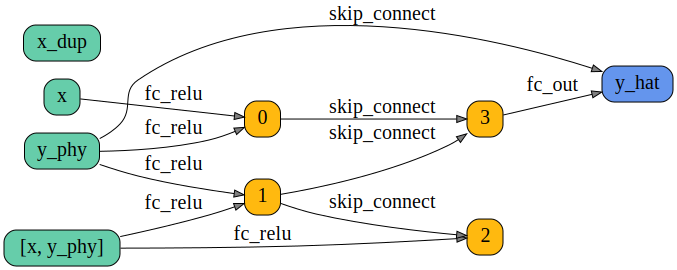

In [7]:
plot_genotype(best_genotype)